# March Machine Learning Mania
In this notebook, we:
- Try different models/features and assess their performance.
- Simulate multiple 2024 March Madness brackets.

## Imports

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from gc import collect
import os
import sys
from tqdm import tqdm

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingRegressor, StackingClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import root_mean_squared_error, r2_score, log_loss, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor, XGBClassifier

from bayes_opt import BayesianOptimization

# display 100 rows and 100 columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 300)

# global random seed
SEED = 0

# set numpy seed
np.random.seed(SEED)

## Load Data

In [6]:
# root dirs
root = 'data/'
mroot = 'data/mens/'
wroot = 'data/womens/'

# load in features compact
features = pd.read_csv(root + 'processed/features_detailed_2.csv')

# team names
# teams = pd.concat([pd.read_csv(mroot + 'MTeams.csv'), pd.read_csv(wroot + 'WTeams.csv')], ignore_index=True)

# create a map for team names
# team_map = teams.set_index('TeamID')['TeamName']

## Rearranging the Data
When we input a new row into our model (for the 2024 bracket), the winner could be the first or the second team in the row that we input into our model. Currently, all rows have the winning team on the left, and this will cause our model to learn this locational information. We need to rearrange the order of winners and losers, to where it is essentially random to prevent the model from learning this.

In [8]:
# add LLoc so the flip works
features['LLoc'] = features['WLoc'].map({'H': 'A', 'A': 'H', 'N': 'N'})

In [9]:
# drop columns that can't be used as features (only used for EDA)
features = features.drop(columns=(['DayNum', 'WRegion', 'LRegion', 'WRegionSeed', 'LRegionSeed']))

In [10]:
# rename W, L to A, B
features.columns = [x.replace('W', 'A_', 1) if x[0] == 'W' else x for x in features.columns]
features.columns = [x.replace('L', 'B_', 1) if x[0] == 'L' else x for x in features.columns]

# check
features.head()

,Season,A_TeamID,A_Score,B_TeamID,B_Score,A_Loc,NumOT,A_Seed,B_Seed,A_PlayIn,B_PlayIn,A_num_games,A_win_ratio,A_avg_Score_for,A_avg_Score_against,A_std_Score_for,A_std_Score_against,A_avg_FGPct2_for,A_avg_FGPct2_against,A_std_FGPct2_for,A_std_FGPct2_against,A_avg_FGPct3_for,A_avg_FGPct3_against,A_std_FGPct3_for,A_std_FGPct3_against,A_avg_FTPct_for,A_avg_FTPct_against,A_std_FTPct_for,A_std_FTPct_against,A_avg_Ast_for,A_avg_Ast_against,A_std_Ast_for,A_std_Ast_against,A_avg_OR_for,A_avg_OR_against,A_std_OR_for,A_std_OR_against,A_avg_DR_for,A_avg_DR_against,A_std_DR_for,A_std_DR_against,A_avg_TO_for,A_avg_TO_against,A_std_TO_for,A_std_TO_against,A_avg_PF_for,A_avg_PF_against,A_std_PF_for,A_std_PF_against,A_avg_diff,A_std_diff,A_home_win_ratio,A_away_win_ratio,A_neutral_win_ratio,A_home_missing,A_away_missing,A_neutral_missing,A_close_game_missing,A_close_game_ratio,A_close_win_ratio,A_recent_win_ratio,A_recent_avg_Score_for,A_recent_avg_Score_against,A_recent_std_Score_for,A_recent_std_Score_against,A_recent_avg_FGPct2_for,A_recent_avg_FGPct2_against,A_recent_std_FGPct2_for,A_recent_std_FGPct2_against,A_recent_avg_FGPct3_for,A_recent_avg_FGPct3_against,A_recent_std_FGPct3_for,A_recent_std_FGPct3_against,A_recent_avg_FTPct_for,A_recent_avg_FTPct_against,A_recent_std_FTPct_for,A_recent_std_FTPct_against,A_recent_avg_Ast_for,A_recent_avg_Ast_against,A_recent_std_Ast_for,A_recent_std_Ast_against,A_recent_avg_OR_for,A_recent_avg_OR_against,A_recent_std_OR_for,A_recent_std_OR_against,A_recent_avg_DR_for,A_recent_avg_DR_against,A_recent_std_DR_for,A_recent_std_DR_against,A_recent_avg_TO_for,A_recent_avg_TO_against,A_recent_std_TO_for,A_recent_std_TO_against,A_recent_avg_PF_for,A_recent_avg_PF_against,A_recent_std_PF_for,A_recent_std_PF_against,A_recent_avg_diff,A_conf_champs,B_num_games,B_win_ratio,B_avg_Score_for,B_avg_Score_against,B_std_Score_for,B_std_Score_against,B_avg_FGPct2_for,B_avg_FGPct2_against,B_std_FGPct2_for,B_std_FGPct2_against,B_avg_FGPct3_for,B_avg_FGPct3_against,B_std_FGPct3_for,B_std_FGPct3_against,B_avg_FTPct_for,B_avg_FTPct_against,B_std_FTPct_for,B_std_FTPct_against,B_avg_Ast_for,B_avg_Ast_against,B_std_Ast_for,B_std_Ast_against,B_avg_OR_for,B_avg_OR_against,B_std_OR_for,B_std_OR_against,B_avg_DR_for,B_avg_DR_against,B_std_DR_for,B_std_DR_against,B_avg_TO_for,B_avg_TO_against,B_std_TO_for,B_std_TO_against,B_avg_PF_for,B_avg_PF_against,B_std_PF_for,B_std_PF_against,B_avg_diff,B_std_diff,B_home_win_ratio,B_away_win_ratio,B_neutral_win_ratio,B_home_missing,B_away_missing,B_neutral_missing,B_close_game_missing,B_close_game_ratio,B_close_win_ratio,B_recent_win_ratio,B_recent_avg_Score_for,B_recent_avg_Score_against,B_recent_std_Score_for,B_recent_std_Score_against,B_recent_avg_FGPct2_for,B_recent_avg_FGPct2_against,B_recent_std_FGPct2_for,B_recent_std_FGPct2_against,B_recent_avg_FGPct3_for,B_recent_avg_FGPct3_against,B_recent_std_FGPct3_for,B_recent_std_FGPct3_against,B_recent_avg_FTPct_for,B_recent_avg_FTPct_against,B_recent_std_FTPct_for,B_recent_std_FTPct_against,B_recent_avg_Ast_for,B_recent_avg_Ast_against,B_recent_std_Ast_for,B_recent_std_Ast_against,B_recent_avg_OR_for,B_recent_avg_OR_against,B_recent_std_OR_for,B_recent_std_OR_against,B_recent_avg_DR_for,B_recent_avg_DR_against,B_recent_std_DR_for,B_recent_std_DR_against,B_recent_avg_TO_for,B_recent_avg_TO_against,B_recent_std_TO_for,B_recent_std_TO_against,B_recent_avg_PF_for,B_recent_avg_PF_against,B_recent_std_PF_for,B_recent_std_PF_against,B_recent_avg_diff,B_conf_champs,round,B_Loc
0,2003,1112,80,1436,51,N,0,1,16,0,0,28,0.892857,85.214286,70.250000,10.222087,8.945104,0.464286,0.428571,0.069324,0.068456,0.321429,0.285714,0.098794,0.075495,0.678571,0.571429,0.106410,0.152864,17.642857,15.464286,4.233511,3.250000,15.178571,13.107143,3.362078,4.064949,27.642857,23.285714,4.076282,3.365175,16.857143,14.785714,5.163690,4.527693,17.750000,22.071429,2.905250,4.435718,14.964286,12.522491,0.933333,0.916667,0.000000,0,0,0,0,0.178571,0.600000,0.666667,83.000000,78.6666

In [11]:
# choose (half) random rows to flip
np.random.seed(SEED)
flip = np.random.choice(features.index, int(features.shape[0] / 2), replace=False)

# flip A, B cols
for i, col in enumerate(features.columns):
    if col[0] == 'A':
        features.loc[flip, col], features.loc[flip, col.replace('A_', 'B_', 1)] = features.loc[flip, col.replace('A_', 'B_', 1)].values, features.loc[flip, col].values

# delete vars
del flip, col
collect()

# rearrange cols
features = features.reindex(sorted(features.columns), axis=1)

# check
features.head()

,A_Loc,A_PlayIn,A_Score,A_Seed,A_TeamID,A_avg_Ast_against,A_avg_Ast_for,A_avg_DR_against,A_avg_DR_for,A_avg_FGPct2_against,A_avg_FGPct2_for,A_avg_FGPct3_against,A_avg_FGPct3_for,A_avg_FTPct_against,A_avg_FTPct_for,A_avg_OR_against,A_avg_OR_for,A_avg_PF_against,A_avg_PF_for,A_avg_Score_against,A_avg_Score_for,A_avg_TO_against,A_avg_TO_for,A_avg_diff,A_away_missing,A_away_win_ratio,A_close_game_missing,A_close_game_ratio,A_close_win_ratio,A_conf_champs,A_home_missing,A_home_win_ratio,A_neutral_missing,A_neutral_win_ratio,A_num_games,A_recent_avg_Ast_against,A_recent_avg_Ast_for,A_recent_avg_DR_against,A_recent_avg_DR_for,A_recent_avg_FGPct2_against,A_recent_avg_FGPct2_for,A_recent_avg_FGPct3_against,A_recent_avg_FGPct3_for,A_recent_avg_FTPct_against,A_recent_avg_FTPct_for,A_recent_avg_OR_against,A_recent_avg_OR_for,A_recent_avg_PF_against,A_recent_avg_PF_for,A_recent_avg_Score_against,A_recent_avg_Score_for,A_recent_avg_TO_against,A_recent_avg_TO_for,A_recent_avg_diff,A_recent_std_Ast_against,A_recent_std_Ast_for,A_recent_std_DR_against,A_recent_std_DR_for,A_recent_std_FGPct2_against,A_recent_std_FGPct2_for,A_recent_std_FGPct3_against,A_recent_std_FGPct3_for,A_recent_std_FTPct_against,A_recent_std_FTPct_for,A_recent_std_OR_against,A_recent_std_OR_for,A_recent_std_PF_against,A_recent_std_PF_for,A_recent_std_Score_against,A_recent_std_Score_for,A_recent_std_TO_against,A_recent_std_TO_for,A_recent_win_ratio,A_std_Ast_against,A_std_Ast_for,A_std_DR_against,A_std_DR_for,A_std_FGPct2_against,A_std_FGPct2_for,A_std_FGPct3_against,A_std_FGPct3_for,A_std_FTPct_against,A_std_FTPct_for,A_std_OR_against,A_std_OR_for,A_std_PF_against,A_std_PF_for,A_std_Score_against,A_std_Score_for,A_std_TO_against,A_std_TO_for,A_std_diff,A_win_ratio,B_Loc,B_PlayIn,B_Score,B_Seed,B_TeamID,B_avg_Ast_against,B_avg_Ast_for,B_avg_DR_against,B_avg_DR_for,B_avg_FGPct2_against,B_avg_FGPct2_for,B_avg_FGPct3_against,B_avg_FGPct3_for,B_avg_FTPct_against,B_avg_FTPct_for,B_avg_OR_against,B_avg_OR_for,B_avg_PF_against,B_avg_PF_for,B_avg_Score_against,B_avg_Score_for,B_avg_TO_against,B_avg_TO_for,B_avg_diff,B_away_missing,B_away_win_ratio,B_close_game_missing,B_close_game_ratio,B_close_win_ratio,B_conf_champs,B_home_missing,B_home_win_ratio,B_neutral_missing,B_neutral_win_ratio,B_num_games,B_recent_avg_Ast_against,B_recent_avg_Ast_for,B_recent_avg_DR_against,B_recent_avg_DR_for,B_recent_avg_FGPct2_against,B_recent_avg_FGPct2_for,B_recent_avg_FGPct3_against,B_recent_avg_FGPct3_for,B_recent_avg_FTPct_against,B_recent_avg_FTPct_for,B_recent_avg_OR_against,B_recent_avg_OR_for,B_recent_avg_PF_against,B_recent_avg_PF_for,B_recent_avg_Score_against,B_recent_avg_Score_for,B_recent_avg_TO_against,B_recent_avg_TO_for,B_recent_avg_diff,B_recent_std_Ast_against,B_recent_std_Ast_for,B_recent_std_DR_against,B_recent_std_DR_for,B_recent_std_FGPct2_against,B_recent_std_FGPct2_for,B_recent_std_FGPct3_against,B_recent_std_FGPct3_for,B_recent_std_FTPct_against,B_recent_std_FTPct_for,B_recent_std_OR_against,B_recent_std_OR_for,B_recent_std_PF_against,B_recent_std_PF_for,B_recent_std_Score_against,B_recent_std_Score_for,B_recent_std_TO_against,B_recent_std_TO_for,B_recent_win_ratio,B_std_Ast_against,B_std_Ast_for,B_std_DR_against,B_std_DR_for,B_std_FGPct2_against,B_std_FGPct2_for,B_std_FGPct3_against,B_std_FGPct3_for,B_std_FTPct_against,B_std_FTPct_for,B_std_OR_against,B_std_OR_for,B_std_PF_against,B_std_PF_for,B_std_Score_against,B_std_Score_for,B_std_TO_against,B_std_TO_for,B_std_diff,B_win_ratio,NumOT,Season,round
0,N,0,80,1,1112,15.464286,17.642857,23.285714,27.642857,0.428571,0.464286,0.285714,0.321429,0.571429,0.678571,13.107143,15.178571,22.071429,17.750000,70.250000,85.214286,14.785714,16.857143,14.964286,0,0.916667,0,0.178571,0.600000,0.0,0,0.933333,0,0.000000,28,13.333333,18.333333,29.000000,25.666667,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,11.666667,16.000000,20.666667,18.666667,78.666667,83.000000,11.666667,17.000000,4.333333,0.333333,0.000000,0.333333,2.666667,0.015

In [12]:
# one-hot encode A_Loc col, drop loc cols
features = pd.get_dummies(features, columns=['A_Loc'], dtype=int)
features = features.drop(columns=['A_Loc_N', 'B_Loc'])

# one-hot encode 'round' col, drop one col
features = pd.get_dummies(features, columns=['round'], dtype=int)
features = features.drop(columns=['round_1'])

## Create Labels

In [13]:
# create regression label, drop cols
features['A_score_diff'] = features['A_Score'] - features['B_Score']
features = features.drop(columns=['A_Score', 'B_Score'])

# create binary label
features['A_win'] = features['A_score_diff'].apply(lambda x: 1 if x > 0 else 0)

# check
features.head()[['A_score_diff', 'A_win']]

,A_score_diff,A_win
0,29,1
1,-13,0
2,-6,0
3,2,1
4,-5,0


In [14]:
# create adjusted score diff col (score diff is inversely scaled by NumOT periods), drop NumOT
features['A_score_diff_adj'] = features['A_score_diff'] / (2 ** features['NumOT'])

# check
features[features['NumOT'] > 0][['A_score_diff', 'NumOT', 'A_score_diff_adj']].sort_values(by='NumOT', ascending=False).head()

,A_score_diff,NumOT,A_score_diff_adj
819,2,2,0.50
184,-6,2,-1.50
864,4,2,1.00
542,-7,2,-1.75
490,5,2,1.25


__score_diff_adj__ and __win__ can both be used as labels. They are both calculated with respect to team A.

In [15]:
# drop cols now that we have adjusted score diff
features = features.drop(columns=['A_score_diff', 'NumOT', 'Season'])

In [16]:
# save updated features
features.to_csv('data/processed/features_detailed_2.csv', index=False)

## Differenced Features
In combination with the team A/B data, we will also try training models using the differences between both teams' aggregated stats.

In [35]:
# features to be kept but shouldn't be differenced
cols_to_keep = ['A_TeamID', 'B_TeamID', 'A_close_game_missing', 'B_close_game_missing', 'A_PlayIn', 'B_PlayIn', 'A_conf_champs', 'B_conf_champs', 'A_away_missing', 'B_away_missing', 
                'A_home_missing', 'B_home_missing', 'A_neutral_missing', 'B_neutral_missing', 'A_Loc_A', 'A_Loc_H', 'round_2', 'round_3', 'round_4', 'round_5', 'round_6', 
                'A_win', 'A_score_diff_adj']

# create diff df
features_diff = features[cols_to_keep].copy()

# get cols that start with A
a_cols_for = [col for col in features.columns if col[0] == 'A' and col[-3:] == 'for']
a_cols_against = [col for col in features.columns if col[0] == 'A' and col[-7:] == 'against']
a_cols = [col for col in features.columns if col[0] == 'A' and col not in a_cols_for and col not in a_cols_against and col not in cols_to_keep]

# create diff cols
for a_col in a_cols_for:
        features_diff[a_col.replace('A_', '', 1) + '_diff'] = features[a_col] - features[a_col.replace('A_', 'B_', 1).replace('for', 'against', 1)]
        features_diff = features_diff.copy()

for a_col in a_cols_against:
    features_diff[a_col.replace('A_', '', 1) + '_diff'] = features[a_col] - features[a_col.replace('A_', 'B_', 1).replace('against', 'for', 1)]
    features_diff = features_diff.copy()

for a_col in a_cols:
    features_diff[a_col.replace('A_', '', 1) + '_diff'] = features[a_col] - features[a_col.replace('A_', 'B_', 1)]
    features_diff = features_diff.copy()

# check
features_diff.head()

,A_TeamID,B_TeamID,A_close_game_missing,B_close_game_missing,A_PlayIn,B_PlayIn,A_conf_champs,B_conf_champs,A_away_missing,B_away_missing,A_home_missing,B_home_missing,A_neutral_missing,B_neutral_missing,A_Loc_A,A_Loc_H,round_2,round_3,round_4,round_5,round_6,A_win,A_score_diff_adj,avg_Ast_for_diff,avg_DR_for_diff,avg_FGPct2_for_diff,avg_FGPct3_for_diff,avg_FTPct_for_diff,avg_OR_for_diff,avg_PF_for_diff,avg_Score_for_diff,avg_TO_for_diff,recent_avg_Ast_for_diff,recent_avg_DR_for_diff,recent_avg_FGPct2_for_diff,recent_avg_FGPct3_for_diff,recent_avg_FTPct_for_diff,recent_avg_OR_for_diff,recent_avg_PF_for_diff,recent_avg_Score_for_diff,recent_avg_TO_for_diff,recent_std_Ast_for_diff,recent_std_DR_for_diff,recent_std_FGPct2_for_diff,recent_std_FGPct3_for_diff,recent_std_FTPct_for_diff,recent_std_OR_for_diff,recent_std_PF_for_diff,recent_std_Score_for_diff,recent_std_TO_for_diff,std_Ast_for_diff,std_DR_for_diff,std_FGPct2_for_diff,std_FGPct3_for_diff,std_FTPct_for_diff,std_OR_for_diff,std_PF_for_diff,std_Score_for_diff,std_TO_for_diff,avg_Ast_against_diff,avg_DR_against_diff,avg_FGPct2_against_diff,avg_FGPct3_against_diff,avg_FTPct_against_diff,avg_OR_against_diff,avg_PF_against_diff,avg_Score_against_diff,avg_TO_against_diff,recent_avg_Ast_against_diff,recent_avg_DR_against_diff,recent_avg_FGPct2_against_diff,recent_avg_FGPct3_against_diff,recent_avg_FTPct_against_diff,recent_avg_OR_against_diff,recent_avg_PF_against_diff,recent_avg_Score_against_diff,recent_avg_TO_against_diff,recent_std_Ast_against_diff,recent_std_DR_against_diff,recent_std_FGPct2_against_diff,recent_std_FGPct3_against_diff,recent_std_FTPct_against_diff,recent_std_OR_against_diff,recent_std_PF_against_diff,recent_std_Score_against_diff,recent_std_TO_against_diff,std_Ast_against_diff,std_DR_against_diff,std_FGPct2_against_diff,std_FGPct3_against_diff,std_FTPct_against_diff,std_OR_against_diff,std_PF_against_diff,std_Score_against_diff,std_TO_against_diff,Seed_diff,avg_diff_diff,away_win_ratio_diff,close_game_ratio_diff,close_win_ratio_diff,home_win_ratio_diff,neutral_win_ratio_diff,num_games_diff,recent_avg_diff_diff,recent_win_ratio_diff,std_diff_diff,win_ratio_diff
0,1112,1436,0,0,0,0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,29.0,4.366995,5.780788,0.016010,0.011084,0.023399,5.592365,-0.181034,22.076355,2.788177,8.000000,8.333333,-0.333333,0.0,-0.333333,6.666667,1.666667,27.000000,4.000000,-2.185813,0.063250,-0.036498,-0.045095,-0.001495,-1.333333,-0.979085,2.118783,-0.642734,0.472958,-1.872091,-0.011725,-0.004007,-0.038919,-0.353891,-1.184266,0.853108,1.706785,1.257389,-2.438424,-0.019704,-0.059113,-0.049261,0.141626,6.174877,2.456897,1.785714,-2.000000,3.666667,-0.333333,-0.333333,0.0,0.666667,5.333333,10.666667,0.333333,-5.031159,-2.572599,-0.066484,-0.023228,0.033645,-0.976068,2.396583,-0.567511,-1.694254,-1.196791,0.168554,-0.019523,-0.041857,0.042668,0.466844,0.408988,-1.805821,0.224081,-15,10.309113,0.416667,-0.269704,0.369231,0.033333,-0.60,-1,-7.666667,-0.333333,-0.007755,0.237685
1,1272,1113,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-13.0,2.551724,5.413793,-0.034483,0.000000,-0.068966,3.068966,-4.103448,5.344828,1.068966,-0.666667,6.333333,0.333333,0.0,0.000000,3.000000,2.333333,1.000000,-4.000000,2.333333,-1.000000,0.092947,0.022791,-0.037166,1.000000,-1.333333,5.000000,0.000000,1.100660,-0.678987,0.022653,0.002199,0.031423,1.220992,-0.911404,-1.592834,1.291776,-2.241379,0.275862,-0.103448,0.034483,-0.034483,-1.344828,0.517241,-10.137931,-1.724138,-5.666667,-1.666667,-0.333333,0.000000,0.0,1.666667,4.666667,-11.333333,-2.000000,0.333333,0.666667,0.018747,0.045894,0.031961,-0.333333,-0.333333,2.000000,-1.666667,-0.651700,-0.076703,-0.006265,-0.027246,0.006705,-0.761436,3.021522,-1.623669,1.023674,-3,1.896552,0.236364,-0.137931,0.012987,0.075000,0.50,0,-3.000000,0.000000,-6.141594,0.172414
2,1166,1141,0,0,0,0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-6.0,5.025078,4.285266,0.066876,0.018809,-0.018809,-1.362591,-4.416928,6.001045,-1.180773,4.333333,10.666667,0.0000

In [36]:
# save updated features
features_diff.to_csv('data/processed/features_detailed_diff_2.csv', index=False)

## Split Data (Checkpoint)

In [37]:
# load in features (checkpoint)
features = pd.read_csv('data/processed/features_detailed_2.csv')
features_diff = pd.read_csv('data/processed/features_detailed_diff_2.csv')

# split on gender
mfeatures = features[features['A_TeamID'] < 3000]
wfeatures = features[features['A_TeamID'] >= 3000]
del features

# same for diff data
mfeatures_diff = features_diff[features_diff['A_TeamID'] < 3000]
wfeatures_diff = features_diff[features_diff['A_TeamID'] >= 3000]
del features_diff

# drop team id cols
mfeatures = mfeatures.drop(columns=['A_TeamID', 'B_TeamID'])
wfeatures = wfeatures.drop(columns=['A_TeamID', 'B_TeamID'])
mfeatures_diff = mfeatures_diff.drop(columns=['A_TeamID', 'B_TeamID'])
wfeatures_diff = wfeatures_diff.drop(columns=['A_TeamID', 'B_TeamID'])

## Chalk Bracket
Here, we will simply predict the better seed. If seeds are equal (only possible in rounds 5 and 6), we will predict the team with the better win_ratio from the regular season.

In [38]:
def get_dummy_preds(data):
    """
    Function to get dummy predictions based on seed and win percentage
    """

    # create a container
    dummy_preds = []

    # loop through the dataframe based on conditions
    for idx, row in data.iterrows():
        if data.loc[idx, "A_Seed"] < data.loc[idx, "B_Seed"]:
            dummy_preds.append(1)
        elif data.loc[idx, "A_Seed"] > data.loc[idx, "B_Seed"]:
            dummy_preds.append(0)
        else:
            if data.loc[idx, "A_win_ratio"] > data.loc[idx, "B_win_ratio"]:
                dummy_preds.append(1)
            else:
                dummy_preds.append(0)
    
    return np.array(dummy_preds)

### Men's

In [39]:
# get dummy preds
mchalk_preds = get_dummy_preds(mfeatures)

# compare preds to win col
mchalk_acc = accuracy_score(mfeatures['A_win'], mchalk_preds)

print(f"Accuracy of dummy predictions: {mchalk_acc*100:.2f}%.")

# delete vars
del mchalk_preds, mchalk_acc

Accuracy of dummy predictions: 70.61%.


### Women's

In [40]:
# get dummy preds
wchalk_preds = get_dummy_preds(wfeatures)

# compare preds to win col
wchalk_acc = accuracy_score(wfeatures['A_win'], wchalk_preds)

print(f"Accuracy of dummy predictions: {wchalk_acc*100:.2f}%")

# delete vars
del wchalk_preds, wchalk_acc

Accuracy of dummy predictions: 78.02%


## Regression/Classification
This problem can be treated as a regression problem (label is __score differential__). It can also be treated as binary classification (label is __win/loss__).

We will try the original aggregated stats for both team A and B as features (mfeatures/wfeatures), and also the differences between the two teams' stats (mfeatures_diff/wfeatures_diff).

In [46]:
# non feature cols
non_feat_cols = ['A_win', 'A_score_diff_adj']

# look at num feats for the 2 datasets
print(f'Features of both team A and B: {mfeatures.shape[1] - len(non_feat_cols)}')
print(f'Features of the DIFFERENCE between team A and B: {mfeatures_diff.shape[1] - len(non_feat_cols)}')

Features of both team A and B: 187
Features of the DIFFERENCE between team A and B: 103


### Data Preprocessing

In [48]:
# cols to remove
cols_to_remove = ['A_Loc_A', 'A_Loc_H', 'round_2', 'round_3', 'round_4', 'round_5', 'round_6', 'A_score_diff_adj', 'A_win']

# create feature order list so our models are trained on the same feature order
sorted_cols = sorted(mfeatures.columns)
sorted_cols = [col for col in sorted_cols if col not in cols_to_remove]
sorted_cols.extend(cols_to_remove)

# same for diff
diff_cols = sorted(mfeatures_diff.columns)
diff_cols = [col for col in diff_cols if col not in cols_to_remove]
diff_cols.extend(cols_to_remove)

# sort all dataframes
mfeatures = mfeatures[sorted_cols]
wfeatures = wfeatures[sorted_cols]
mfeatures_diff = mfeatures_diff[diff_cols]
wfeatures_diff = wfeatures_diff[diff_cols]

In [49]:
# function that takes in estimator, data, models_df, tournament, test_size
def run_model(estimator, data, regression, models_df, tournament, scaler=None, folds=5):
    """
    Run a model on data and save results to models_df.

    Parameters
    ----------
    estimator : sklearn estimator
        Estimator to use for modeling.
    data : pd.DataFrame
        Data to model.
    regression : bool
        Whether to model score differential (regression) or win/loss (classification).
    scaler : sklearn scaler
        Scaler to use for data.
    models_df : pd.DataFrame
        DataFrame to save results to.
    tournament : str
        Gender - 'M' or 'F'.
    folds : int
        Number of cross-validation folds to use.

    Returns
    -------
    models_df.tail() : pd.DataFrame
        Last 5 rows of dataframe with results from model.
    """
    
    # create copy to avoid modification
    data = data.copy()

    # define cross-validation
    kf = KFold(n_splits=folds, shuffle=True, random_state=SEED)

    # predicting score differential
    if regression:
        # define X and y
        X = data.drop(columns=['A_score_diff_adj', 'A_win'])
        y = data['A_score_diff_adj']

        # initialize lists to store metrics
        rmse_scores_train = []
        rmse_scores_test = []
        r2_scores_train = []
        r2_scores_test = []
        acc_scores_train = []
        acc_scores_test = []

        for train_index, test_index in kf.split(X):
            # split data
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            if scaler:
                # scale data
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)

            # fit model
            estimator.fit(X_train, y_train)

            # predict
            train_preds = estimator.predict(X_train)
            test_preds = estimator.predict(X_test)

            # evaluate
            rmse_scores_train.append(root_mean_squared_error(y_train, train_preds))
            rmse_scores_test.append(root_mean_squared_error(y_test, test_preds))
            r2_scores_train.append(r2_score(y_train, train_preds))
            r2_scores_test.append(r2_score(y_test, test_preds))
            acc_scores_train.append(accuracy_score(np.sign(y_train), np.sign(train_preds)))
            acc_scores_test.append(accuracy_score(np.sign(y_test), np.sign(test_preds)))

        # average the metrics across folds
        train_rmse = np.mean(rmse_scores_train)
        test_rmse = np.mean(rmse_scores_test)
        train_r2 = np.mean(r2_scores_train)
        test_r2 = np.mean(r2_scores_test)
        train_acc = np.mean(acc_scores_train)
        test_acc = np.mean(acc_scores_test)
        
        # Save results to models_df
        models_df.loc[len(models_df.index)] = [tournament, 'A_score_diff_adj', estimator, scaler, X.shape[1], X.columns.to_list(), folds, train_r2, test_r2, train_rmse, test_rmse, train_acc, test_acc]

        # delete variables
        collect()
        
        return
    
    # predicting win/loss
    else:
        # define X and y
        X = data.drop(columns=['A_score_diff_adj', 'A_win'])
        y = data['A_win']

        # initialize lists to store metrics
        log_loss_train = []
        log_loss_test = []
        acc_scores_train = []
        acc_scores_test = []

        for train_index, test_index in kf.split(X):
            # split data
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            if scaler:
                # scale data
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)

            # fit model
            estimator.fit(X_train, y_train)

            # predict
            train_preds = estimator.predict(X_train)
            test_preds = estimator.predict(X_test)


            # evaluate
            log_loss_train.append(log_loss(y_train, train_preds))
            log_loss_test.append(log_loss(y_test, test_preds))
            acc_scores_train.append(accuracy_score(np.sign(y_train), np.sign(train_preds)))
            acc_scores_test.append(accuracy_score(np.sign(y_test), np.sign(test_preds)))

        # average the metrics across folds
        train_log_loss = np.mean(log_loss_train)
        test_log_loss = np.mean(log_loss_test)
        train_acc = np.mean(acc_scores_train)
        test_acc = np.mean(acc_scores_test)
        
        # save results to models_df
        models_df.loc[len(models_df.index)] = [tournament, 'A_win', estimator, scaler, X.shape[1], X.columns.to_list(), folds, train_log_loss, test_log_loss, train_acc, test_acc]

        # delete variables
        collect()
        
        return

### Regression (Predicting <ins>Score Differential</ins>)

#### Men's

In [50]:
# create a df to hold regression models
# reg_df = pd.DataFrame(columns=['Tournament', 'Label', 'Model', 'Scaler', 'Num_Features', 'Features', 'Num_CV_Folds', 'Train_R2', 'Val_R2', 'Train_RMSE', 'Val_RMSE', 'Train_Acc', 'Val_Acc'])

# load reg df
reg_df = pd.read_csv('models/regression_models_detailed.csv')

In [61]:
# define regression models
reg_models = [LinearRegression(n_jobs=-1), DecisionTreeRegressor(random_state=SEED), RandomForestRegressor(n_jobs=-1, random_state=SEED), XGBRegressor(n_jobs=-1, random_state=SEED), 
              SVR(), KNeighborsRegressor(n_jobs=-1)] 
mdatasets = [mfeatures, mfeatures_diff]
scalers = [None, StandardScaler(), MinMaxScaler()]

# run regression models
for model in tqdm(reg_models, desc='Model', file=sys.stdout):
    for dataset in mdatasets:
        for scaler in scalers:
            # run model
            run_model(estimator=model, data=dataset, regression=True, models_df=reg_df, tournament='M', scaler=scaler)

Model: 100%|██████████| 6/6 [00:55<00:00,  9.20s/it]


In [94]:
# inspect
reg_df[(reg_df['Tournament'] == 'M') & ((reg_df['Num_Features'] == 187) | (reg_df['Num_Features'] == 103))].sort_values(by='Val_Acc', ascending=False).head()

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_R2,Val_R2,Train_RMSE,Val_RMSE,Train_Acc,Val_Acc
588,M,A_score_diff_adj,"(DecisionTreeRegressor(max_depth=57, max_featu...",StandardScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.527736,0.176618,9.891346,11.848842,0.789515,0.690185
518,M,A_score_diff_adj,LinearRegression(n_jobs=-1),StandardScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.453685,0.149627,10.638552,12.029315,0.739277,0.690182
590,M,A_score_diff_adj,"(DecisionTreeRegressor(max_depth=12, max_featu...",StandardScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.411314,0.157384,11.043682,11.990630,0.744239,0.688598
541,M,A_score_diff_adj,SVR(),None,103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.347095,0.098846,11.630550,12.357914,0.740267,0.687795
618,M,A_score_diff_adj,"(DecisionTreeRegressor(max_depth=1, max_featur...",StandardScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.263642,0.036717,12.351454,12.823327,0.712667,0.687020


#### Women's

In [66]:
# women's data
wdatasets = [wfeatures, wfeatures_diff]

# run regression models
for model in tqdm(reg_models, desc='Model', file=sys.stdout):
    for dataset in wdatasets:
        for scaler in scalers:
            # run model
            run_model(estimator=model, data=dataset, regression=True, models_df=reg_df, tournament='W', scaler=scaler)

Model: 100%|██████████| 6/6 [00:35<00:00,  5.96s/it]


In [67]:
# inspect
reg_df[(reg_df['Tournament'] == 'W') & ((reg_df['Num_Features'] == 187) | (reg_df['Num_Features'] == 103))].sort_values(by='Val_Acc', ascending=False).head()

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_R2,Val_R2,Train_RMSE,Val_RMSE,Train_Acc,Val_Acc
565,W,A_score_diff_adj,"(DecisionTreeRegressor(max_features=1.0, rando...",None,103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.948245,0.630329,4.878968,12.939552,0.946583,0.783892
554,W,A_score_diff_adj,LinearRegression(n_jobs=-1),StandardScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.734587,0.633552,11.050619,12.896513,0.816239,0.779021
555,W,A_score_diff_adj,LinearRegression(n_jobs=-1),MinMaxScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.734588,0.633503,11.050612,12.897201,0.816849,0.777802
567,W,A_score_diff_adj,"(DecisionTreeRegressor(max_features=1.0, rando...",MinMaxScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.948528,0.628644,4.865155,12.973494,0.947190,0.776567
566,W,A_score_diff_adj,"(DecisionTreeRegressor(max_features=1.0, rando...",StandardScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.947111,0.622819,4.931863,13.080967,0.942000,0.776552


In [68]:
# save reg_df
reg_df.to_csv('models/regression_models_detailed.csv', index=False)

### Classification (Predicting <ins>Win/Loss</ins>)

In [69]:
# create a df to hold regression models
# class_df = pd.DataFrame(columns=['Tournament', 'Label', 'Model', 'Scaler', 'Num_Features', 'Features', 'Num_CV_Folds', 'Train_LogLoss', 'Val_LogLoss', 'Train_Acc', 'Val_Acc'])

# load reg df
class_df = pd.read_csv('models/classification_models_detailed.csv')

#### Men's

In [70]:
# define classification models
class_models = [LogisticRegression(n_jobs=-1, random_state=SEED), DecisionTreeClassifier(), RandomForestClassifier(n_jobs=-1, random_state=SEED), XGBClassifier(n_jobs=-1, random_state=SEED), 
                SVC(), KNeighborsClassifier(n_jobs=-1)]

# run models
for model in tqdm(class_models, desc='Model', file=sys.stdout):
    for dataset in mdatasets:
        for scaler in scalers:
            # run model
            run_model(estimator=model, data=dataset, regression=False, models_df=class_df, tournament='M', scaler=scaler)

Model: 100%|██████████| 6/6 [00:51<00:00,  8.63s/it]


In [75]:
# inspect
class_df[(class_df['Tournament'] == 'M') & ((class_df['Num_Features'] == 187) | (class_df['Num_Features'] == 103))].sort_values(by='Val_Acc', ascending=False).head()

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_LogLoss,Val_LogLoss,Train_Acc,Val_Acc
601,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",MinMaxScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,9.082464,11.911524,0.748015,0.669525
599,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,9.061052,12.254341,0.748609,0.660014
600,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",StandardScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,8.989459,12.311667,0.750595,0.658423
623,M,A_win,SVC(),None,103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,7.350405,12.398739,0.796069,0.656008
625,M,A_win,SVC(),MinMaxScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,7.185778,12.714089,0.800637,0.647259


#### Women's

In [72]:
# run models
for model in tqdm(class_models, desc='Model', file=sys.stdout):
    for dataset in wdatasets:
        for scaler in scalers:
            # run model
            run_model(estimator=model, data=dataset, regression=False, models_df=class_df, tournament='W', scaler=scaler)

Model: 100%|██████████| 6/6 [00:26<00:00,  4.35s/it]


In [73]:
# inspect
class_df[(class_df['Tournament'] == 'W') & ((class_df['Num_Features'] == 187) | (class_df['Num_Features'] == 103))].sort_values(by='Val_Acc', ascending=False).head()

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_LogLoss,Val_LogLoss,Train_Acc,Val_Acc
659,W,A_win,SVC(),None,103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,5.644211e+00,8.318140,0.843406,0.769220
634,W,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",MinMaxScaler(),187,"[A_PlayIn, A_Seed, A_avg_Ast_against, A_avg_As...",5,4.797108e+00,8.450007,0.866908,0.765562
637,W,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",MinMaxScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,6.018153e+00,8.450007,0.833032,0.765562
658,W,A_win,SVC(),MinMaxScaler(),187,"[A_PlayIn, A_Seed, A_avg_Ast_against, A_avg_As...",5,4.059860e+00,8.493693,0.887363,0.764350
648,W,A_win,"(DecisionTreeClassifier(max_features='sqrt', r...",StandardScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,2.220446e-16,8.538727,1.000000,0.763100


In [76]:
# save class_df
class_df.to_csv('models/classification_models_detailed.csv', index=False)

### Takeaways:
- The differenced data performed better in all cases.

## Model tuning
In this section, we look at some of the most promising models from the "Regression/Classification" section and attempt to milk as much accuracy as possible.

### Men's

#### Regression

In [96]:
# random forest regressor
def rf_objective_function(max_samples, max_features, max_depth, min_samples_split, min_samples_leaf):
    """
    Objective function for Bayesian optimization of random forest hyperparameters.
    """

    # convert to integer
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)

    # create model
    model = RandomForestRegressor(n_estimators=1000, max_samples=max_samples, max_features=max_features, max_depth=max_depth, min_samples_split=min_samples_split, 
                                  min_samples_leaf=min_samples_leaf, n_jobs=-1, random_state=SEED)

    # run model
    run_model(estimator=model, data=mfeatures_diff, regression=True, models_df=reg_df, tournament='M', scaler=MinMaxScaler())

    # return negative validation RMSE
    return -reg_df[reg_df['Tournament'] == 'M']['Val_RMSE'].values[-1]

# define bounds
rf_bounds = {
    'max_samples': (0.5, 1),
    'max_features': (0.5, 1),
    'max_depth': (1, 100),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20)
}

# create optimizer
rf_optimizer = BayesianOptimization(f=rf_objective_function, pbounds=rf_bounds, random_state=SEED)

# run optimization
rf_optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   | max_depth | max_fe... | max_sa... | min_sa... | min_sa... |
-------------------------------------------------------------------------------------
| 1         | -11.81    | 55.33     | 0.8576    | 0.8014    | 11.35     | 9.626     |
| 2         | -11.79    | 64.94     | 0.7188    | 0.9459    | 19.31     | 8.902     |
| 3         | -11.8     | 79.38     | 0.7644    | 0.784     | 18.59     | 3.279     |
| 4         | -11.82    | 9.626     | 0.5101    | 0.9163    | 15.78     | 17.66     |
| 5         | -11.81    | 97.88     | 0.8996    | 0.7307    | 15.83     | 4.129     |
| 6         | -11.81    | 64.35     | 0.5717    | 0.9723    | 10.92     | 9.464     |
| 7         | -11.79    | 27.19     | 0.8871    | 0.7281    | 11.8      | 2.338     |
| 8         | -11.81    | 62.15     | 0.806     | 0.8085    | 18.93     | 14.27     |
| 9         | -11.83    | 36.59     | 0.7185    | 0.8488    | 2.144     | 14.0      |
| 10        | -11.81    | 67.39     | 0.6052    | 0.56

In [97]:
# get best params
rf_optimizer.max

{'target': -11.789767053451914,
 'params': {'max_depth': 64.94351719359895,
  'max_features': 0.7187936056313462,
  'max_samples': 0.9458865003910399,
  'min_samples_leaf': 19.309592449519556,
  'min_samples_split': 8.901947338863998}}

In [98]:
# xgboost regressor
def xgb_objective_function(max_depth, learning_rate, gamma, min_child_weight, subsample, colsample_bytree, reg_alpha, reg_lambda):
    """
    Objective function for Bayesian optimization of XGBoost hyperparameters.
    """

    # convert to integer
    max_depth = int(max_depth)

    # create model
    model = XGBRegressor(n_estimators=10000, max_depth=max_depth, learning_rate=learning_rate, gamma=gamma, min_child_weight=min_child_weight, subsample=subsample, 
                         colsample_bytree=colsample_bytree, reg_alpha=reg_alpha, reg_lambda=reg_lambda, n_jobs=-1, random_state=SEED)

    # run model
    run_model(estimator=model, data=mfeatures_diff, regression=True, models_df=reg_df, tournament='M', scaler=MinMaxScaler())

    # return negative validation RMSE
    return -reg_df[reg_df['Tournament'] == 'M']['Val_RMSE'].values[-1]

# define bounds
xgb_bounds = {
    'max_depth': (1, 10),
    'learning_rate': (0.0001, 0.001),
    'gamma': (0, 10),
    'min_child_weight': (1, 10),
    'subsample': (0.6, 1),
    'colsample_bytree': (0.5, 1),
    'reg_alpha': (0, 10),
    'reg_lambda': (0, 10)
}

# create optimizer
xgb_optimizer = BayesianOptimization(f=xgb_objective_function, pbounds=xgb_bounds, random_state=SEED)

# run optimization
xgb_optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------


| 1         | -12.01    | 0.7744    | 7.152     | 0.0006425 | 5.904     | 4.813     | 6.459     | 4.376     | 0.9567    |
| 2         | -12.0     | 0.9818    | 3.834     | 0.0008126 | 5.76      | 6.112     | 9.256     | 0.7104    | 0.6349    |
| 3         | -12.03    | 0.5101    | 8.326     | 0.0008003 | 8.83      | 9.808     | 7.992     | 4.615     | 0.9122    |
| 4         | -12.14    | 0.5591    | 6.399     | 0.000229  | 9.502     | 5.697     | 4.147     | 2.646     | 0.9097    |
| 5         | -12.58    | 0.7281    | 5.684     | 0.0001169 | 6.559     | 6.509     | 6.169     | 9.437     | 0.8727    |
| 6         | -11.79    | 0.6798    | 4.37      | 0.0007279 | 1.542     | 7.001     | 6.706     | 2.104     | 0.6516    |
| 7         | -11.95    | 0.6577    | 3.637     | 0.0006132 | 4.947     | 9.895     | 1.02      | 2.089     | 0.6645    |
| 8         | -11.88    | 0.8266    | 2.533     | 0.0005197 | 3.2       | 2.431     | 1.104     | 6.563     | 0.6553    |
| 9         | -11.8     

In [99]:
# get best params
xgb_optimizer.max

{'target': -11.782002180080617,
 'params': {'colsample_bytree': 0.9883805440951685,
  'gamma': 6.04845519745046,
  'learning_rate': 0.0007653372214584715,
  'max_depth': 1.352690130288886,
  'min_child_weight': 3.5452626631876862,
  'reg_alpha': 1.201965612131689,
  'reg_lambda': 2.9614019752214493,
  'subsample': 0.6474910875816976}}

##### Residuals

In [103]:
def plot_preds(data, preds, title):
    """
    Plot predictions vs. actual values.
    """

    # create figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))

    # scatter plot
    ax.scatter(data, preds, alpha=0.5)

    # add line
    ax.plot([data.min(), data.max()], [data.min(), data.max()], 'k--', lw=2)

    # labels
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(title)

    plt.show()

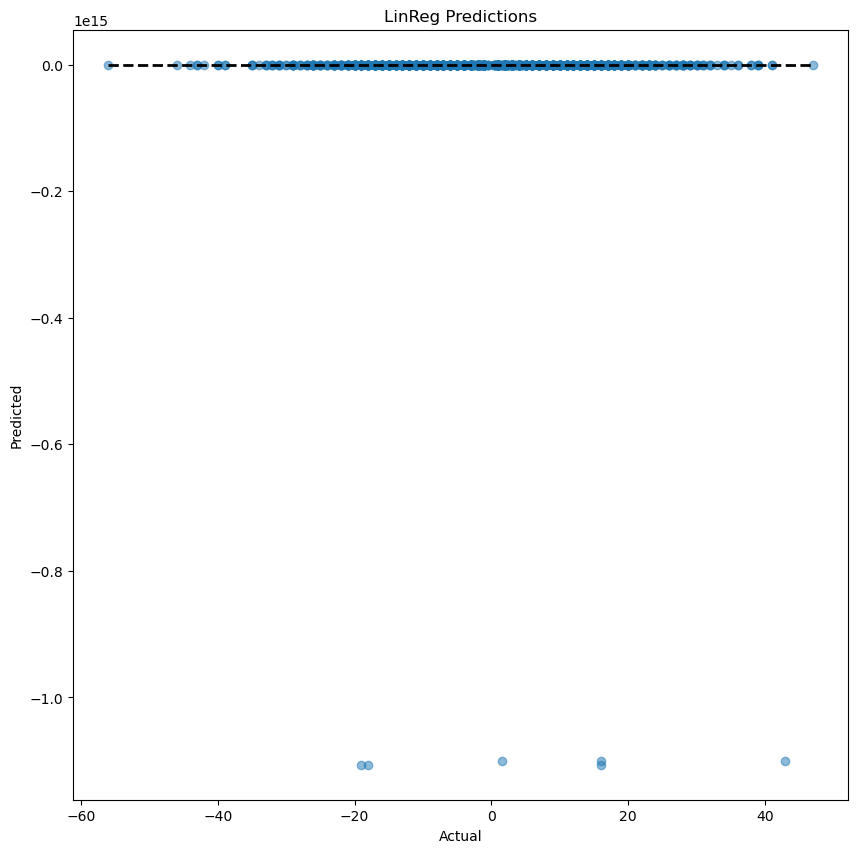

In [104]:
# create model
linreg_model = LinearRegression(n_jobs=-1)

# scale data
mfeatures_diff_scaled = MinMaxScaler().fit_transform(mfeatures_diff.drop(columns=['A_score_diff_adj', 'A_win']))

# cross validate, get preds
linreg_preds = cross_val_predict(linreg_model, mfeatures_diff_scaled, mfeatures_diff['A_score_diff_adj'], cv=5)

# plot preds
plot_preds(mfeatures_diff['A_score_diff_adj'], linreg_preds, 'LinReg Predictions')

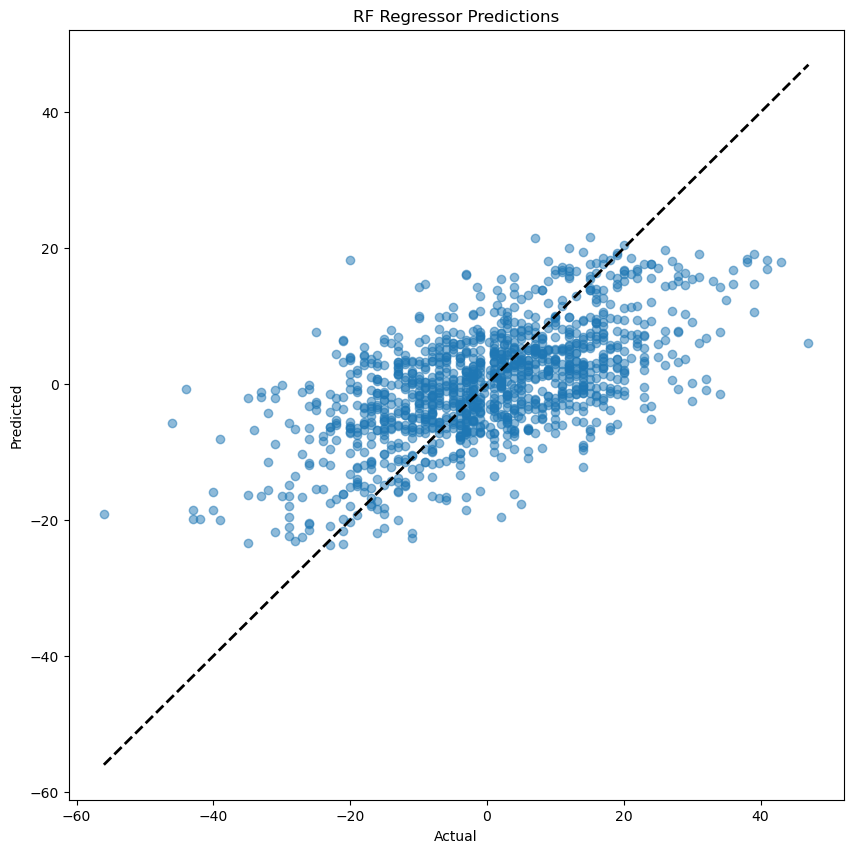

In [106]:
# create model
rf_model = RandomForestRegressor(n_estimators=1000, max_samples=0.946, max_features=0.719, max_depth=64, min_samples_split=8, min_samples_leaf=19, n_jobs=-1, random_state=SEED)

# cross validate, get preds
rf_preds = cross_val_predict(rf_model, mfeatures_diff_scaled, mfeatures_diff['A_score_diff_adj'], cv=5)

# plot preds
plot_preds(mfeatures_diff['A_score_diff_adj'], rf_preds, 'RF Regressor Predictions')

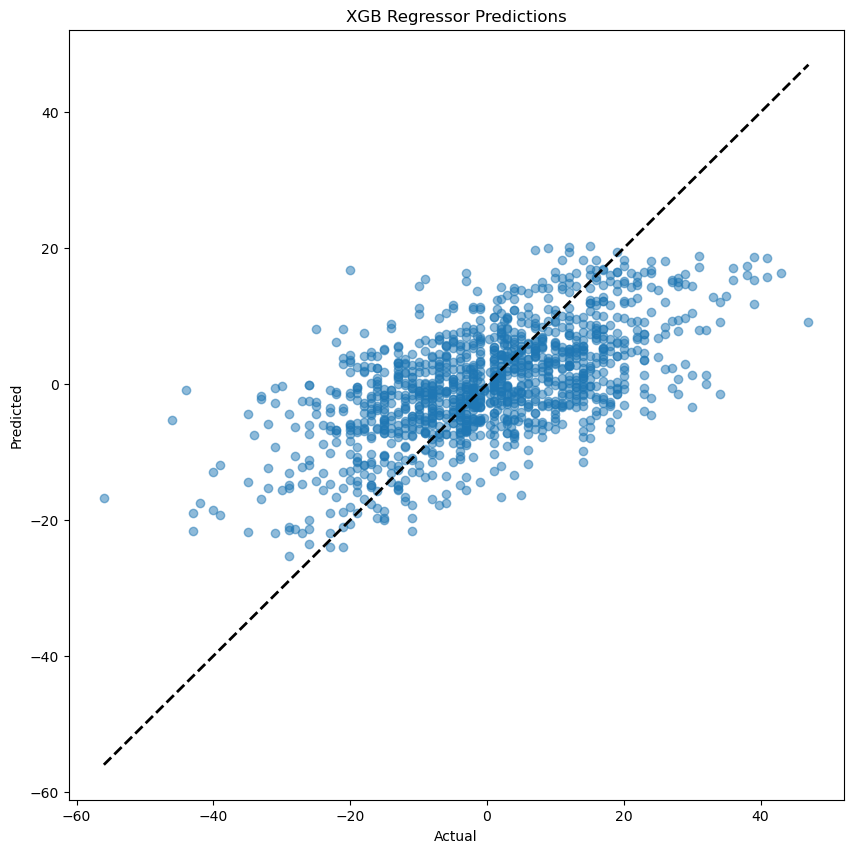

In [110]:
# create model
xgb_model = XGBRegressor(n_estimators=10000, max_depth=1, learning_rate=0.00077, gamma=6.048, min_child_weight=3.545, subsample=0.647, colsample_bytree=0.988, reg_alpha=1.202, reg_lambda=2.961, 
                         n_jobs=-1, random_state=SEED)

# cross validate, get preds
xgb_preds = cross_val_predict(xgb_model, mfeatures_diff_scaled, mfeatures_diff['A_score_diff_adj'], cv=5)

# plot preds
plot_preds(mfeatures_diff['A_score_diff_adj'], xgb_preds, 'XGB Regressor Predictions')

##### Stacking Regressor

In [115]:
# create stacking regressor
stacking_model = StackingRegressor(estimators=[('rf', rf_model), ('xgb', xgb_model), ('linreg', linreg_model)], final_estimator=LinearRegression(n_jobs=-1))

# cross validate
run_model(estimator=stacking_model, data=mfeatures_diff, regression=True, models_df=reg_df, tournament='M', scaler=MinMaxScaler())

# look at results
reg_df[reg_df['Tournament'] == 'M'].tail()

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_R2,Val_R2,Train_RMSE,Val_RMSE,Train_Acc,Val_Acc
973,M,A_score_diff_adj,"XGBRegressor(base_score=None, booster=None, ca...",MinMaxScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.435117,0.184568,10.817868,11.803782,0.736099,0.675100
974,M,A_score_diff_adj,"XGBRegressor(base_score=None, booster=None, ca...",MinMaxScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.445907,0.183591,10.714050,11.810515,0.741858,0.671125
975,M,A_score_diff_adj,"XGBRegressor(base_score=None, booster=None, ca...",MinMaxScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.441347,0.183332,10.758056,11.812226,0.740468,0.675096
976,M,A_score_diff_adj,"StackingRegressor(estimators=[('rf',\n ...",MinMaxScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.493412,0.190769,10.244076,11.745068,0.764496,0.687011
977,M,A_score_diff_adj,"StackingRegressor(estimators=[('rf',\n ...",MinMaxScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.492329,0.190661,10.255009,11.745254,0.764297,0.686217


In [116]:
# save
reg_df.to_csv('models/regression_models_detailed.csv', index=False)

In [117]:
reg_df[(reg_df['Tournament'] == 'M') & ((reg_df['Num_Features'] == 187) | (reg_df['Num_Features'] == 103))].sort_values(by='Val_RMSE', ascending=True).head()


,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_R2,Val_R2,Train_RMSE,Val_RMSE,Train_Acc,Val_Acc
976,M,A_score_diff_adj,"StackingRegressor(estimators=[('rf',\n ...",MinMaxScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.493412,0.190769,10.244076,11.745068,0.764496,0.687011
977,M,A_score_diff_adj,"StackingRegressor(estimators=[('rf',\n ...",MinMaxScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.492329,0.190661,10.255009,11.745254,0.764297,0.686217
875,M,A_score_diff_adj,"XGBRegressor(base_score=None, booster=None, ca...",MinMaxScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.432860,0.186923,10.839437,11.782002,0.734709,0.676677
871,M,A_score_diff_adj,"XGBRegressor(base_score=None, booster=None, ca...",MinMaxScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.427267,0.186173,10.892734,11.787612,0.733518,0.676677
757,M,A_score_diff_adj,"(DecisionTreeRegressor(max_depth=64, max_featu...",MinMaxScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.560212,0.185458,9.545322,11.789767,0.803614,0.677481


In [118]:
reg_df[(reg_df['Tournament'] == 'M') & ((reg_df['Num_Features'] == 187) | (reg_df['Num_Features'] == 103))].sort_values(by='Val_Acc', ascending=False).head(2)

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_R2,Val_R2,Train_RMSE,Val_RMSE,Train_Acc,Val_Acc
774,M,A_score_diff_adj,"(DecisionTreeRegressor(max_depth=1, max_featur...",MinMaxScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.264217,0.038579,12.346583,12.804629,0.710086,0.696576
588,M,A_score_diff_adj,"(DecisionTreeRegressor(max_depth=57, max_featu...",StandardScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.527736,0.176618,9.891346,11.848842,0.789515,0.690185


Best Men's regression model resulted in 69.7% accuracy.

#### Classification

In [121]:
# random forest classifier
def rf_objective_function(max_samples, max_features, max_depth, min_samples_split, min_samples_leaf):
    """
    Objective function for Bayesian optimization of random forest classifier hyperparameters.
    """

    # convert to integer
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)

    # create model
    model = RandomForestClassifier(n_estimators=1000, max_samples=max_samples, max_features=max_features, max_depth=max_depth, min_samples_split=min_samples_split, 
                                   min_samples_leaf=min_samples_leaf, n_jobs=-1, random_state=SEED)

    # run model
    run_model(estimator=model, data=mfeatures_diff, regression=False, models_df=class_df, tournament='M', scaler=MinMaxScaler())

    # return negative validation log loss
    return -class_df[class_df['Tournament'] == 'M']['Val_LogLoss'].values[-1]

# define bounds
rf_bounds = {
    'max_samples': (0.5, 1),
    'max_features': (0.5, 1),
    'max_depth': (1, 100),
    'min_samples_split': (2, 30),
    'min_samples_leaf': (1, 30)
}

# create optimizer
rf_optimizer = BayesianOptimization(f=rf_objective_function, pbounds=rf_bounds, random_state=SEED)

# run optimization
rf_optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   | max_depth | max_fe... | max_sa... | min_sa... | min_sa... |
-------------------------------------------------------------------------------------
| 1         | -12.03    | 55.33     | 0.8576    | 0.8014    | 16.8      | 13.86     |
| 2         | -12.03    | 64.94     | 0.7188    | 0.9459    | 28.95     | 12.74     |
| 3         | -11.71    | 79.38     | 0.7644    | 0.784     | 27.84     | 3.989     |
| 4         | -11.91    | 9.626     | 0.5101    | 0.9163    | 23.57     | 26.36     |
| 5         | -11.65    | 97.88     | 0.8996    | 0.7307    | 23.64     | 5.312     |
| 6         | -11.85    | 64.35     | 0.5717    | 0.9723    | 16.13     | 13.61     |
| 7         | -11.68    | 27.19     | 0.8871    | 0.7281    | 17.48     | 2.526     |
| 8         | -11.77    | 62.15     | 0.806     | 0.8085    | 28.37     | 21.09     |
| 9         | -12.03    | 36.59     | 0.7185    | 0.8488    | 2.747     | 20.67     |
| 10        | -11.85    | 67.39     | 0.6052    | 0.56

In [122]:
# get best params
rf_optimizer.max

{'target': -11.482318595312568,
 'params': {'max_depth': 44.1579553070938,
  'max_features': 1.0,
  'max_samples': 0.5,
  'min_samples_leaf': 22.473952559963823,
  'min_samples_split': 23.483574218411345}}

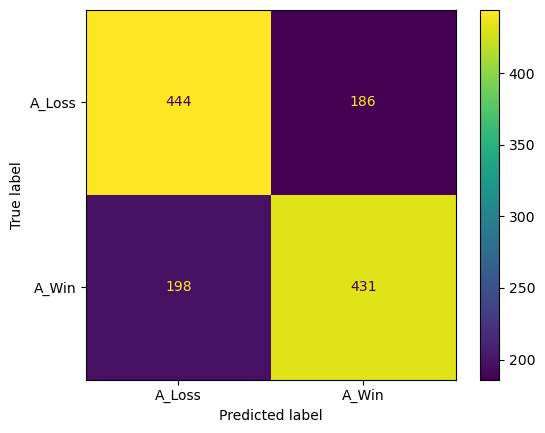

In [123]:
# analyze best logreg
logreg_model = LogisticRegression(n_jobs=-1, random_state=SEED)

# confusion matrix
logreg_cm = confusion_matrix(mfeatures_diff['A_win'], cross_val_predict(logreg_model, mfeatures_diff_scaled, mfeatures_diff['A_win'], cv=5))
ConfusionMatrixDisplay(logreg_cm, display_labels=['A_Loss', 'A_Win']).plot();

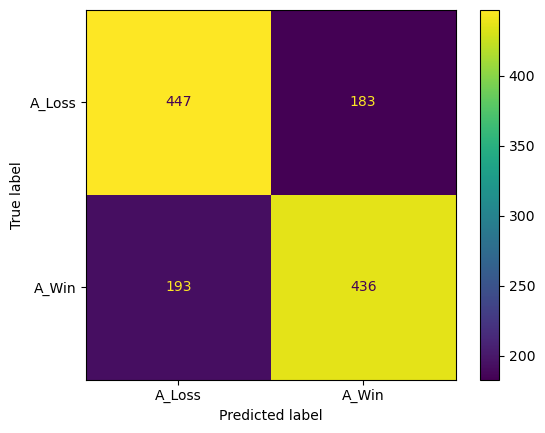

In [124]:
# analyze best logreg
svc_model = SVC()

# confusion matrix
svc_cm = confusion_matrix(mfeatures_diff['A_win'], cross_val_predict(svc_model, mfeatures_diff_scaled, mfeatures_diff['A_win'], cv=5))
ConfusionMatrixDisplay(svc_cm, display_labels=['A_Loss', 'A_Win']).plot();

In [125]:
rf_optimizer.max

{'target': -11.482318595312568,
 'params': {'max_depth': 44.1579553070938,
  'max_features': 1.0,
  'max_samples': 0.5,
  'min_samples_leaf': 22.473952559963823,
  'min_samples_split': 23.483574218411345}}

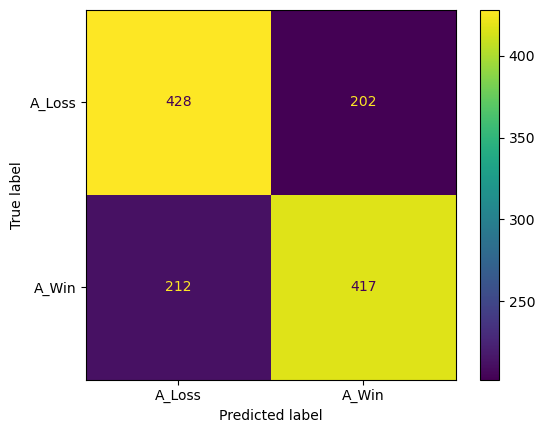

In [126]:
# analyze best rf
rf_model = RandomForestClassifier(n_estimators=1000, max_samples=0.5, max_features=1, max_depth=44, min_samples_split=23, min_samples_leaf=22, n_jobs=-1, random_state=SEED)

# confusion matrix
rf_cm = confusion_matrix(mfeatures_diff['A_win'], cross_val_predict(rf_model, mfeatures_diff_scaled, mfeatures_diff['A_win'], cv=5))
ConfusionMatrixDisplay(rf_cm, display_labels=['A_Loss', 'A_Win']).plot();

##### Stacking Classifier

In [133]:
# stacking classifier
stacking_model = StackingClassifier(estimators=[('svc', svc_model), ('rf', rf_model)], final_estimator=LogisticRegression(n_jobs=-1, random_state=SEED))

# cross validate
run_model(estimator=stacking_model, data=mfeatures_diff, regression=False, models_df=class_df, tournament='M', scaler=MinMaxScaler())

# look at results
class_df[class_df['Tournament'] == 'M'].tail()

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_LogLoss,Val_LogLoss,Train_Acc,Val_Acc
777,M,A_win,"(DecisionTreeClassifier(max_depth=15, max_feat...",MinMaxScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,8.073468,11.797783,0.776009,0.672681
778,M,A_win,"StackingClassifier(estimators=[('logreg',\n ...",MinMaxScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,7.715409,12.542111,0.785943,0.652030
779,M,A_win,"StackingClassifier(estimators=[('logreg',\n ...",MinMaxScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,7.729719,12.541997,0.785546,0.652033
780,M,A_win,"StackingClassifier(estimators=[('logreg',\n ...",MinMaxScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,8.975092,12.169662,0.750994,0.662363
781,M,A_win,"StackingClassifier(estimators=[('svc', SVC()),...",MinMaxScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,7.185785,12.542111,0.800637,0.652030


##### Results

In [134]:
# save
class_df.to_csv('models/classification_models_detailed.csv', index=False)

In [135]:
class_df[class_df['Tournament'] == 'M'].sort_values(by='Val_LogLoss', ascending=True).head(2)

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_LogLoss,Val_LogLoss,Train_Acc,Val_Acc
317,M,A_win,"RandomForestClassifier(max_depth=45, max_featu...",MinMaxScaler(),148,"['1_score_game_ratio_diff', '1_score_win_ratio...",5,8.581630,11.080580,0.761910,0.692579
315,M,A_win,"RandomForestClassifier(max_depth=46, max_featu...",MinMaxScaler(),148,"['1_score_game_ratio_diff', '1_score_win_ratio...",5,8.724767,11.195346,0.757939,0.689395


In [136]:
class_df[class_df['Tournament'] == 'M'].sort_values(by='Val_Acc', ascending=False).head(2)

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_LogLoss,Val_LogLoss,Train_Acc,Val_Acc
317,M,A_win,"RandomForestClassifier(max_depth=45, max_featu...",MinMaxScaler(),148,"['1_score_game_ratio_diff', '1_score_win_ratio...",5,8.581630,11.080580,0.761910,0.692579
315,M,A_win,"RandomForestClassifier(max_depth=46, max_featu...",MinMaxScaler(),148,"['1_score_game_ratio_diff', '1_score_win_ratio...",5,8.724767,11.195346,0.757939,0.689395


Best Men's classification model resulted in 69.3% accuracy.

### Women's

#### Regression

In [137]:
reg_df[(reg_df['Tournament'] == 'W') & ((reg_df['Num_Features'] == 187) | (reg_df['Num_Features'] == 103))].sort_values(by='Val_Acc', ascending=False).head(20)

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_R2,Val_R2,Train_RMSE,Val_RMSE,Train_Acc,Val_Acc
565,W,A_score_diff_adj,"(DecisionTreeRegressor(max_features=1.0, rando...",None,103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.948245,0.630329,4.878968,12.939552,0.946583,0.783892
554,W,A_score_diff_adj,LinearRegression(n_jobs=-1),StandardScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.734587,0.633552,11.050619,12.896513,0.816239,0.779021
555,W,A_score_diff_adj,LinearRegression(n_jobs=-1),MinMaxScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.734588,0.633503,11.050612,12.897201,0.816849,0.777802
567,W,A_score_diff_adj,"(DecisionTreeRegressor(max_features=1.0, rando...",MinMaxScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.948528,0.628644,4.865155,12.973494,0.947190,0.776567
566,W,A_score_diff_adj,"(DecisionTreeRegressor(max_features=1.0, rando...",StandardScaler(),103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.947111,0.622819,4.931863,13.080967,0.942000,0.776552
577,W,A_score_diff_adj,SVR(),None,103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.482585,0.452245,15.431639,15.811106,0.789985,0.775318
553,W,A_score_diff_adj,LinearRegression(n_jobs=-1),None,103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.721181,0.616336,11.325045,13.170577,0.809826,0.770485
551,W,A_score_diff_adj,LinearRegression(n_jobs=-1),StandardScaler(),187,"[A_PlayIn, A_Seed, A_avg_Ast_against, A_avg_As...",5,0.781138,0.612796,10.035693,13.271862,0.838522,0.770477
552,W,A_score_diff_adj,LinearRegression(n_jobs=-1),MinMaxScaler(),187,"[A_PlayIn, A_Seed, A_avg_Ast_against, A_avg_As...",5,0.781201,0.612368,10.034237,13.278654,0.837912,0.770470
564,W,A_score_diff_adj,"(DecisionTreeRegressor(max_features=1.0, rando...",MinMaxScaler(),187,"[A_PlayIn, A_Seed, A_avg_Ast_against, A_avg_As...",5,0.947501,0.621709,4.915026,13.070778,0.951161,0.770462


In [139]:
# random forest regressor
def rf_objective_function(max_samples, max_features, max_depth, min_samples_split, min_samples_leaf):
    """
    Objective function for Bayesian optimization of random forest hyperparameters.
    """

    # convert to integer
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)

    # create model
    model = RandomForestRegressor(n_estimators=1000, max_samples=max_samples, max_features=max_features, max_depth=max_depth, min_samples_split=min_samples_split, 
                                  min_samples_leaf=min_samples_leaf, n_jobs=-1, random_state=SEED)

    # run model
    run_model(estimator=model, data=wfeatures_diff, regression=True, models_df=reg_df, tournament='W', scaler=None)

    # return negative validation RMSE
    return -reg_df[reg_df['Tournament'] == 'W']['Val_RMSE'].values[-1]

# define bounds
rf_bounds = {
    'max_samples': (0.5, 1),
    'max_features': (0.5, 1),
    'max_depth': (1, 100),
    'min_samples_split': (2, 50),
    'min_samples_leaf': (1, 50)
}

# create optimizer
rf_optimizer = BayesianOptimization(f=rf_objective_function, pbounds=rf_bounds, random_state=SEED)

# run optimization
rf_optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   | max_depth | max_fe... | max_sa... | min_sa... | min_sa... |
-------------------------------------------------------------------------------------
| 1         | 0.7778    | 55.33     | 0.8576    | 0.8014    | 27.7      | 22.34     |
| 2         | 0.7802    | 64.94     | 0.7188    | 0.9459    | 48.22     | 20.41     |
| 3         | 0.7802    | 79.38     | 0.7644    | 0.784     | 46.35     | 5.41      |
| 4         | 0.7863    | 9.626     | 0.5101    | 0.9163    | 39.13     | 43.76     |
| 5         | 0.7741    | 97.88     | 0.8996    | 0.7307    | 39.25     | 7.677     |
| 6         | 0.7802    | 64.35     | 0.5717    | 0.9723    | 26.57     | 21.9      |
| 7         | 0.7778    | 27.19     | 0.8871    | 0.7281    | 28.85     | 2.902     |
| 8         | 0.7814    | 62.15     | 0.806     | 0.8085    | 47.24     | 34.73     |
| 9         | 0.7753    | 36.59     | 0.7185    | 0.8488    | 3.951     | 34.0      |
| 10        | 0.7802    | 67.39     | 0.6052    | 0.56

In [140]:
# get best params
rf_optimizer.max

{'target': 0.786301062397127,
 'params': {'max_depth': 9.62580067045253,
  'max_features': 0.5101091987201629,
  'max_samples': 0.916309922773969,
  'min_samples_leaf': 39.12968079654267,
  'min_samples_split': 43.76058311584732}}

##### Residuals

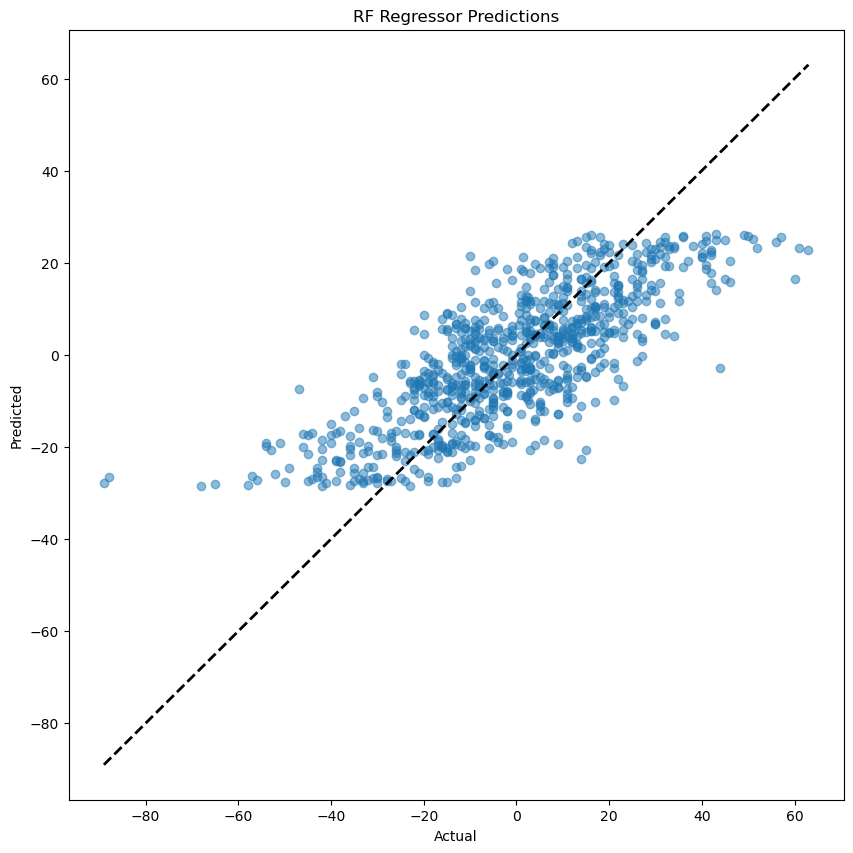

In [141]:
# create model
rf_model = RandomForestRegressor(n_estimators=1000, max_samples=0.916, max_features=0.51, max_depth=9, min_samples_split=43, min_samples_leaf=39, n_jobs=-1, random_state=SEED)

# cross validate, get preds
rf_preds = cross_val_predict(rf_model, wfeatures_diff.drop(columns=['A_score_diff_adj', 'A_win']), wfeatures_diff['A_score_diff_adj'], cv=5)

# plot preds
plot_preds(wfeatures_diff['A_score_diff_adj'], rf_preds, 'RF Regressor Predictions')

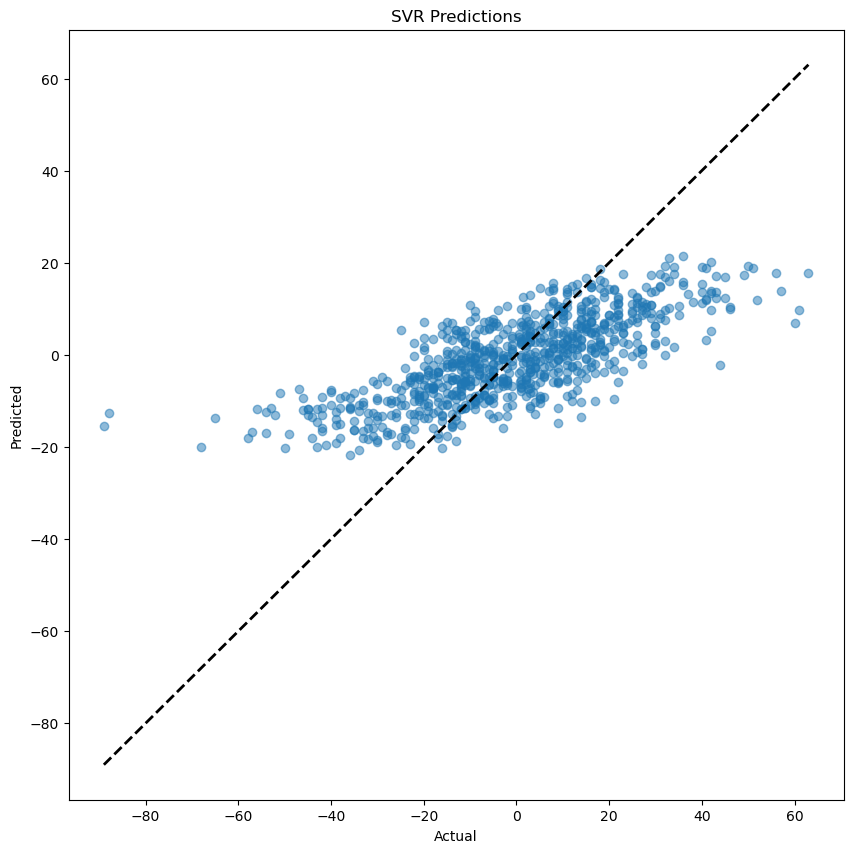

In [142]:
# create model
svr_model = SVR()

# cross validate, get preds
svr_preds = cross_val_predict(svr_model, wfeatures_diff.drop(columns=['A_score_diff_adj', 'A_win']), wfeatures_diff['A_score_diff_adj'], cv=5)

# plot preds
plot_preds(wfeatures_diff['A_score_diff_adj'], svr_preds, 'SVR Predictions')

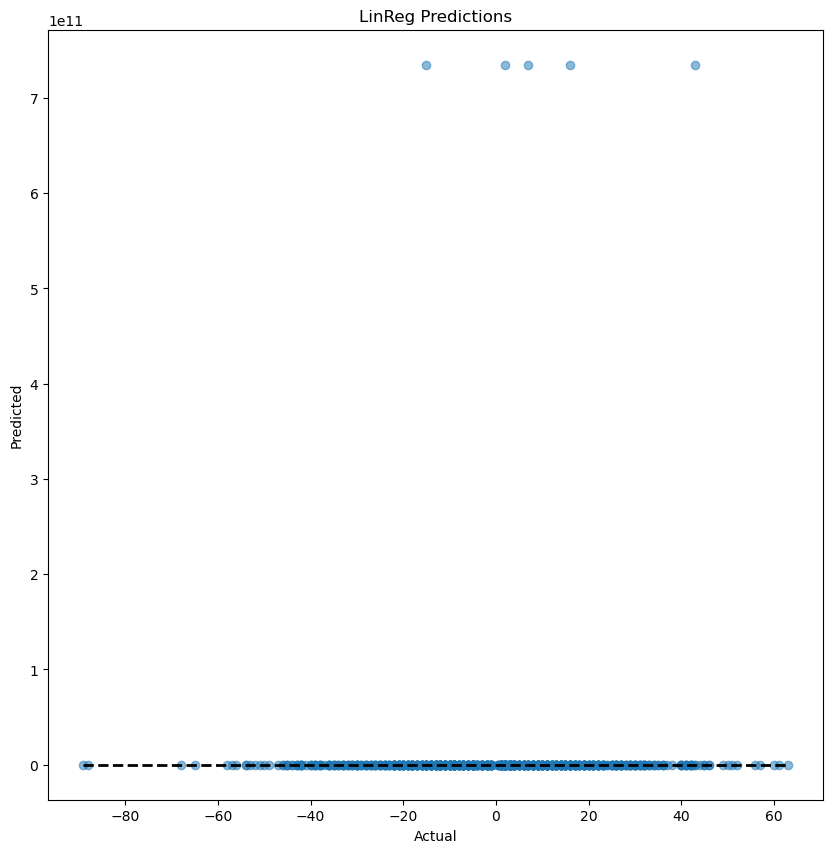

In [143]:
# create model
linreg_model = LinearRegression(n_jobs=-1)

# cross validate, get preds
linreg_preds = cross_val_predict(linreg_model, wfeatures_diff.drop(columns=['A_score_diff_adj', 'A_win']), wfeatures_diff['A_score_diff_adj'], cv=5)

# plot preds
plot_preds(wfeatures_diff['A_score_diff_adj'], linreg_preds, 'LinReg Predictions')

##### Stacking Regressor

In [156]:
# create stacking regressor
stacking_model = StackingRegressor(estimators=[('rf', rf_model), ('svr', svr_model)], final_estimator=LinearRegression(n_jobs=-1))

# cross validate
run_model(estimator=stacking_model, data=wfeatures_diff, regression=True, models_df=reg_df, tournament='W', scaler=None)

# look at results
reg_df[reg_df['Tournament'] == 'W'].tail()

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_R2,Val_R2,Train_RMSE,Val_RMSE,Train_Acc,Val_Acc
1132,W,A_score_diff_adj,"(DecisionTreeRegressor(max_depth=59, max_featu...",None,103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.631330,0.585797,13.023717,13.751059,0.791514,0.783862
1133,W,A_score_diff_adj,"(DecisionTreeRegressor(max_depth=12, max_featu...",None,103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.649920,0.595114,12.690957,13.587249,0.798534,0.777757
1134,W,A_score_diff_adj,"(DecisionTreeRegressor(max_depth=62, max_featu...",None,103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.569222,0.539954,14.080125,14.504557,0.787544,0.777764
1135,W,A_score_diff_adj,"(DecisionTreeRegressor(max_depth=15, max_featu...",None,103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.619499,0.578645,13.231170,13.874072,0.783275,0.776567
1136,W,A_score_diff_adj,"StackingRegressor(estimators=[('rf',\n ...",None,103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.653653,0.598868,12.622822,13.521059,0.797924,0.781423


In [159]:
# save
reg_df.to_csv('models/regression_models_detailed.csv', index=False)

In [160]:
reg_df[reg_df['Tournament'] == 'W'].sort_values(by='Val_RMSE', ascending=True).head(2)

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_R2,Val_R2,Train_RMSE,Val_RMSE,Train_Acc,Val_Acc
513,W,A_score_diff_adj,"StackingRegressor(estimators=[('rf',\n ...",StandardScaler(),148,"['1_score_game_ratio_diff', '1_score_win_ratio...",5,0.958917,0.643671,4.304065,12.702220,0.950551,0.792399
508,W,A_score_diff_adj,"XGBRegressor(base_score=None, booster=None, ca...",StandardScaler(),148,"['1_score_game_ratio_diff', '1_score_win_ratio...",5,0.998365,0.637855,0.867478,12.798673,0.997253,0.783884


In [161]:
reg_df[reg_df['Tournament'] == 'W'].sort_values(by='Val_Acc', ascending=False).head(2)

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_R2,Val_R2,Train_RMSE,Val_RMSE,Train_Acc,Val_Acc
452,W,A_score_diff_adj,"XGBRegressor(base_score=None, booster=None, ca...",StandardScaler(),148,"['1_score_game_ratio_diff', '1_score_win_ratio...",5,0.998411,0.628047,0.854873,12.951137,0.997864,0.792421
513,W,A_score_diff_adj,"StackingRegressor(estimators=[('rf',\n ...",StandardScaler(),148,"['1_score_game_ratio_diff', '1_score_win_ratio...",5,0.958917,0.643671,4.304065,12.702220,0.950551,0.792399


Best Women's regression model resulted in 79.24% accuracy.

#### Classification

In [184]:
class_df[(class_df['Tournament'] == 'W')].sort_values(by='Val_Acc', ascending=False).iloc[0]['Model']

"StackingClassifier(estimators=[('logreg',\n                                LogisticRegression(n_jobs=-1, random_state=0)),\n                               ('xgb',\n                                XGBClassifier(base_score=None, booster=None,\n                                              callbacks=None,\n                                              colsample_bylevel=None,\n                                              colsample_bynode=None,\n                                              colsample_bytree=0.581,\n                                              device=None,\n                                              early_stopping_rounds=None,\n                                              enable_categorical=False,\n                                              eval_metric=None,\n                                              feature_types=None, gamma=5.48,\n                                              grow_policy=None,\n                                              im...\n            

In [163]:
# random forest classifier
def rf_objective_function(max_samples, max_features, max_depth, min_samples_split, min_samples_leaf):
    """
    Objective function for Bayesian optimization of random forest hyperparameters.
    """

    # convert to integer
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)

    # create model
    model = RandomForestClassifier(n_estimators=1000, max_samples=max_samples, max_features=max_features, max_depth=max_depth, min_samples_split=min_samples_split, 
                                  min_samples_leaf=min_samples_leaf, n_jobs=-1, random_state=SEED)

    # run model
    run_model(estimator=model, data=wfeatures_diff, regression=False, models_df=class_df, tournament='W', scaler=None)

    # return validation loss
    return -class_df[class_df['Tournament'] == 'W']['Val_LogLoss'].values[-1]

# define bounds
rf_bounds = {
    'max_samples': (0.5, 1),
    'max_features': (0.5, 1),
    'max_depth': (1, 100),
    'min_samples_split': (2, 50),
    'min_samples_leaf': (1, 50)
}

# create optimizer
rf_optimizer = BayesianOptimization(f=rf_objective_function, pbounds=rf_bounds, random_state=SEED)

# run optimization
rf_optimizer.maximize(init_points=10, n_iter=200)

|   iter    |  target   | max_depth | max_fe... | max_sa... | min_sa... | min_sa... |
-------------------------------------------------------------------------------------
| 1         | -7.921    | 55.33     | 0.8576    | 0.8014    | 27.7      | 22.34     |
| 2         | -8.098    | 64.94     | 0.7188    | 0.9459    | 48.22     | 20.41     |
| 3         | -8.142    | 79.38     | 0.7644    | 0.784     | 46.35     | 5.41      |
| 4         | -7.702    | 9.626     | 0.5101    | 0.9163    | 39.13     | 43.76     |
| 5         | -8.097    | 97.88     | 0.8996    | 0.7307    | 39.25     | 7.677     |
| 6         | -7.746    | 64.35     | 0.5717    | 0.9723    | 26.57     | 21.9      |
| 7         | -8.009    | 27.19     | 0.8871    | 0.7281    | 28.85     | 2.902     |
| 8         | -8.098    | 62.15     | 0.806     | 0.8085    | 47.24     | 34.73     |
| 9         | -8.01     | 36.59     | 0.7185    | 0.8488    | 3.951     | 34.0      |
| 10        | -7.834    | 67.39     | 0.6052    | 0.56

In [164]:
# get best params
rf_optimizer.max

{'target': -7.701681436429641,
 'params': {'max_depth': 9.62580067045253,
  'max_features': 0.5101091987201629,
  'max_samples': 0.916309922773969,
  'min_samples_leaf': 39.12968079654267,
  'min_samples_split': 43.76058311584732}}

In [165]:
# xgboost
def xgb_objective_function(max_depth, learning_rate, gamma, min_child_weight, subsample, colsample_bytree, reg_alpha, reg_lambda):
    """
    Objective function for Bayesian optimization of XGBoost hyperparameters.
    """

    # convert to integer
    max_depth = int(max_depth)

    # create model
    model = XGBClassifier(n_estimators=10000, max_depth=max_depth, learning_rate=learning_rate, gamma=gamma, min_child_weight=min_child_weight, subsample=subsample, 
                          colsample_bytree=colsample_bytree, reg_alpha=reg_alpha, reg_lambda=reg_lambda, n_jobs=-1, random_state=SEED)

    # run model
    run_model(estimator=model, data=wfeatures_diff, regression=False, models_df=class_df, tournament='W', scaler=None)

    # return negative validation log loss
    return -class_df[class_df['Tournament'] == 'W']['Val_LogLoss'].values[-1]

# define bounds
xgb_bounds = {
    'max_depth': (1, 10),
    'learning_rate': (0.0001, 0.01),
    'gamma': (0, 10),
    'min_child_weight': (1, 10),
    'subsample': (0.6, 1),
    'colsample_bytree': (0.5, 1),
    'reg_alpha': (0, 10),
    'reg_lambda': (0, 10)
}

# create optimizer
xgb_optimizer = BayesianOptimization(f=xgb_objective_function, pbounds=xgb_bounds, random_state=SEED)

# run optimization
xgb_optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | -7.922    | 0.7744    | 7.152     | 0.006067  | 5.904     | 4.813     | 6.459     | 4.376     | 0.9567    |
| 2         | -8.098    | 0.9818    | 3.834     | 0.007938  | 5.76      | 6.112     | 9.256     | 0.7104    | 0.6349    |
| 3         | -7.966    | 0.5101    | 8.326     | 0.007804  | 8.83      | 9.808     | 7.992     | 4.615     | 0.9122    |
| 4         | -7.966    | 0.5591    | 6.399     | 0.001519  | 9.502     | 5.697     | 4.147     | 2.646     | 0.9097    |
| 5         | -7.878    | 0.7281    | 5.684     | 0.000286  | 6.559     | 6.509     | 6.169     | 9.437     | 0.8727    |
| 6         | -7.878    | 0.6798    | 4.37      | 0.007007  | 1.542     | 7.001     | 6.706     | 2.104     | 0.6516    |
| 7         | -8.098    

In [166]:
# get best params
xgb_optimizer.max

{'target': -7.6140397534170505,
 'params': {'colsample_bytree': 0.5011935562261394,
  'gamma': 1.0914804043223754,
  'learning_rate': 0.008464957624478279,
  'max_depth': 3.120090485101317,
  'min_child_weight': 4.1163328965225405,
  'reg_alpha': 8.34206284290769,
  'reg_lambda': 6.432780851611058,
  'subsample': 0.6}}

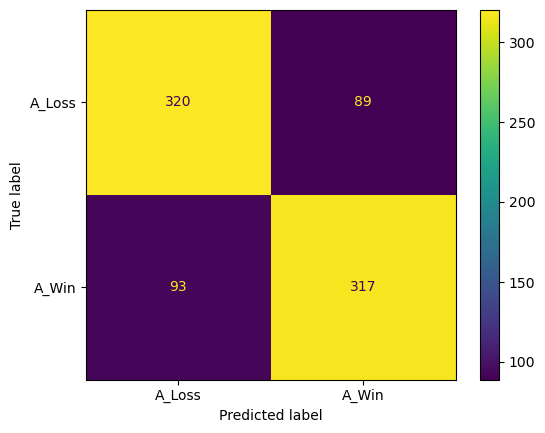

In [167]:
# analyze best logreg
logreg_model = LogisticRegression(n_jobs=-1, random_state=SEED)

# confusion matrix
logreg_cm = confusion_matrix(wfeatures_diff['A_win'], cross_val_predict(logreg_model, wfeatures_diff.drop(columns=['A_score_diff_adj', 'A_win']), 
                wfeatures_diff['A_win'], cv=5))

ConfusionMatrixDisplay(logreg_cm, display_labels=['A_Loss', 'A_Win']).plot();

In [170]:
rf_optimizer.max

{'target': -7.701681436429641,
 'params': {'max_depth': 9.62580067045253,
  'max_features': 0.5101091987201629,
  'max_samples': 0.916309922773969,
  'min_samples_leaf': 39.12968079654267,
  'min_samples_split': 43.76058311584732}}

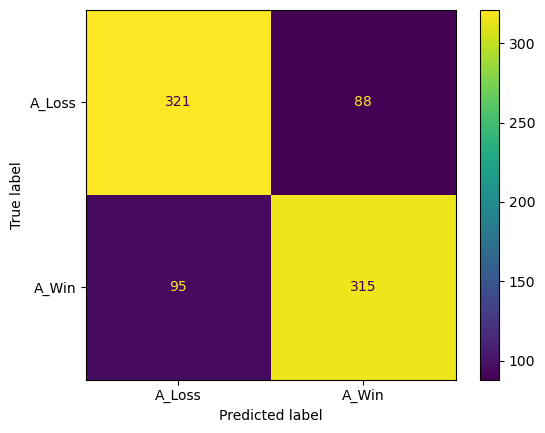

In [171]:
# analyze best rf
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=9, max_features=0.51, max_samples=0.916, min_samples_leaf=39, min_samples_split=43, n_jobs=-1, random_state=SEED)

# confusion matrix
rf_cm = confusion_matrix(wfeatures_diff['A_win'], cross_val_predict(rf_model, wfeatures_diff.drop(columns=['A_score_diff_adj', 'A_win']), 
                wfeatures_diff['A_win'], cv=5))

ConfusionMatrixDisplay(rf_cm, display_labels=['A_Loss', 'A_Win']).plot();

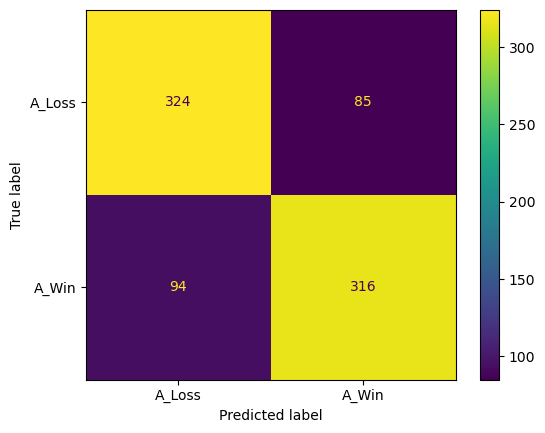

In [169]:
# analyze best xgb
xgb_model = XGBClassifier(n_estimators=10000, max_depth=3, learning_rate=0.00846, gamma=1.091, min_child_weight=4.116, subsample=0.6, colsample_bytree=0.501, reg_alpha=8.342, reg_lambda=6.433, 
                          n_jobs=-1, random_state=SEED)

# confusion matrix
xgb_cm = confusion_matrix(wfeatures_diff['A_win'], cross_val_predict(xgb_model, wfeatures_diff.drop(columns=['A_score_diff_adj', 'A_win']), 
                wfeatures_diff['A_win'], cv=5))

ConfusionMatrixDisplay(xgb_cm, display_labels=['A_Loss', 'A_Win']).plot();

##### Stacking Classifier

In [185]:
# stacking classifier
stacking_model = StackingClassifier(estimators=[('xgb', xgb_model), ('logreg', logreg_model)], final_estimator=LogisticRegression(n_jobs=-1))

# cross validate
run_model(estimator=stacking_model, data=wfeatures_diff, regression=False, models_df=class_df, tournament='W', scaler=None)

# look at results
class_df[class_df['Tournament'] == 'W'].tail()

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_LogLoss,Val_LogLoss,Train_Acc,Val_Acc
1100,W,A_win,"XGBClassifier(base_score=None, booster=None, c...",None,103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,0.363071,8.185733,0.989927,0.772894
1101,W,A_win,"XGBClassifier(base_score=None, booster=None, c...",None,103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,3.014604,8.274184,0.916362,0.770440
1102,W,A_win,"StackingClassifier(estimators=[('logreg',\n ...",None,103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,5.523114,8.273645,0.846766,0.770455
1103,W,A_win,"StackingClassifier(estimators=[('xgb',\n ...",None,103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,5.864224,7.570084,0.837302,0.789975
1104,W,A_win,"StackingClassifier(estimators=[('xgb',\n ...",None,103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,5.721116,7.876965,0.841273,0.781460


##### Results

In [186]:
# save
class_df.to_csv('models/classification_models_detailed.csv', index=False)

In [187]:
class_df[class_df['Tournament'] == 'W'].sort_values(by='Val_LogLoss', ascending=True).head(2)

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_LogLoss,Val_LogLoss,Train_Acc,Val_Acc
594,W,A_win,"StackingClassifier(estimators=[('logreg',\n ...",MinMaxScaler(),148,"['1_score_game_ratio_diff', '1_score_win_ratio...",5,5.688250,6.822568,0.842184,0.810714
523,W,A_win,"XGBClassifier(base_score=None, booster=None, c...",MinMaxScaler(),148,"['1_score_game_ratio_diff', '1_score_win_ratio...",5,6.040265,7.175022,0.832418,0.800935


In [188]:
class_df[class_df['Tournament'] == 'W'].sort_values(by='Val_Acc', ascending=False).head(2)

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_LogLoss,Val_LogLoss,Train_Acc,Val_Acc
594,W,A_win,"StackingClassifier(estimators=[('logreg',\n ...",MinMaxScaler(),148,"['1_score_game_ratio_diff', '1_score_win_ratio...",5,5.688250,6.822568,0.842184,0.810714
523,W,A_win,"XGBClassifier(base_score=None, booster=None, c...",MinMaxScaler(),148,"['1_score_game_ratio_diff', '1_score_win_ratio...",5,6.040265,7.175022,0.832418,0.800935


Best Women's classification model resulted in 81.07% accuracy.

### Discretizer for Classification
We will use KBinsDiscretizer to transform our continuous statistics into discrete variables. This adds non-linearity to linear models like LogReg and SVC.

#### Men's

In [194]:
# look at default logreg performance on men's
logreg_model = LogisticRegression(n_jobs=-1, random_state=SEED)

# cross validate
run_model(estimator=logreg_model, data=mfeatures_diff, regression=False, models_df=class_df, tournament='M', scaler=None)

# look at results
class_df[class_df['Tournament'] == 'M'].tail(1)

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_LogLoss,Val_LogLoss,Train_Acc,Val_Acc
1105,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[A_PlayIn, A_away_missing, A_close_game_missin...",5,9.061052,12.254341,0.748609,0.660014


In [215]:
# get categorical cols
cat_cols = [col for col in cols_to_keep if col not in ['A_TeamID', 'B_TeamID']]

# 5 different bin sizes
for bin in [60, 70, 80, 90, 100]:
    mfeatures_discrete = KBinsDiscretizer(n_bins=bin, encode='ordinal', strategy='uniform', subsample=None).fit_transform(mfeatures_diff.drop(columns=cat_cols))
    mfeatures_discrete = pd.DataFrame(mfeatures_discrete, columns=mfeatures_diff.drop(columns=cat_cols).columns)
    mfeatures_discrete = pd.concat([mfeatures_discrete, mfeatures_diff[cat_cols]], axis=1)

    # run model
    run_model(estimator=logreg_model, data=mfeatures_discrete, regression=False, models_df=class_df, tournament='M', scaler=None)

# look at results
class_df[class_df['Tournament'] == 'M'].tail()

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_LogLoss,Val_LogLoss,Train_Acc,Val_Acc
1126,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.125402,12.168978,0.746824,0.662382
1127,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.096774,11.825022,0.747618,0.671925
1128,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.268574,11.968508,0.742851,0.667944
1129,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.168375,11.968394,0.745631,0.667947
1130,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.182706,11.996772,0.745234,0.667160


In [217]:
class_df[class_df['Tournament'] == 'M'].tail(15)

,Tournament,Label,Model,Scaler,Num_Features,Features,Num_CV_Folds,Train_LogLoss,Val_LogLoss,Train_Acc,Val_Acc
1116,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.003776,12.053870,0.750198,0.665576
1117,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.139797,12.025036,0.746424,0.666376
1118,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.061059,12.626676,0.748609,0.649684
1119,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.061045,11.967482,0.748609,0.667973
1120,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.168375,12.053414,0.745631,0.665588
1121,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.039548,11.595717,0.749206,0.678287
1122,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.032411,11.825136,0.749404,0.671922
1123,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.125465,11.853856,0.746822,0.671125
1124,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.154050,12.025492,0.746029,0.666363
1125,M,A_win,"LogisticRegression(n_jobs=-1, random_state=0)",None,103,"[Seed_diff, avg_Ast_against_diff, avg_Ast_for_...",5,9.082485,11.738748,0.748014,0.674319


## Simultate N Brackets

In [19]:
# root dirs
root = 'data/'
mroot = 'data/mens/'
wroot = 'data/womens/'

# load data, get slots for 2024, drop play-ins
slots = pd.read_csv(mroot + 'MNCAATourneySlots.csv')
slots = slots[slots['Season'] == 2024]
slots = slots[slots['Slot'].str.contains('R')].reset_index(drop=True)

# load seed data
seeds_2024 = pd.read_csv(root + '2024_tourney_seeds.csv')

# load in 2024 data
df_2024 = pd.read_csv(root + 'processed/2024_features.csv').drop(columns=['Region', 'Season'])

# drop teams not in 2024 tourney
df_2024 = df_2024[df_2024['TeamID'].isin(seeds_2024['TeamID'])]

# drop play in char
df_2024['FullSeed'] = df_2024['FullSeed'].apply(lambda x: x[:3])

# split into mens and womens
mdf_2024 = df_2024[df_2024['TeamID'] < 3000].reset_index(drop=True)
wdf_2024 = df_2024[df_2024['TeamID'] >= 3000].reset_index(drop=True)

# delete vars
del root, mroot, wroot, seeds_2024, df_2024

In [33]:
def generate_bracket(data, estimator, tournament, num_brackets, slots_df=slots):
    """
    Generate a single bracket for the 2024 NCAA tournament.

    Parameters
    ----------
    data : pd.DataFrame
        Regular season data for the 2024 teams competing in the tournament.
    estimator : sklearn estimator
        Pre-trained estimator to use for modeling.
    tournament : str
        'M' or 'W'.
    num_brackets : int
        Number of brackets to generate.
    slots : pd.DataFrame
        Slots for the 2024 tournament.

    Returns
    -------
    all_brackets : pd.DataFrame
        DataFrame with the predicted outcomes of the tournament.
    
    """

    # get a copies of data to avoid modifying the original
    features = data.copy()

    # define scaler
    scaler = MinMaxScaler()

    # create empty df for all brackets
    all_brackets = pd.DataFrame()

    # loop for each bracket
    for n in range(1, num_brackets+1):
        # create bracket-specific slots table
        slots = slots_df.copy()

        # create empty results for round
        result_df = pd.DataFrame(columns=["Slot", "Team"])

        # 6 rounds in a single bracket
        for i in range(1, 7):
            # get slots for round
            slots_round = slots[slots['Slot'].str.contains(f'R{i}')].reset_index(drop=True)

            # holds data for each matchup
            round_matchups = []

            # loop through the slots
            for idx, row in slots_round.iterrows():
                # get team A and team B
                A = features[features['FullSeed'] == row['StrongSeed']].reset_index(drop=True)
                B = features[features['FullSeed'] == row['WeakSeed']].reset_index(drop=True)

                # rename cols
                A = A.add_prefix('A_')
                B = B.add_prefix('B_')

                # create matchup dataframe
                combined = pd.concat([A, B], axis=1)

                # append combined row to the list
                round_matchups.append(combined)

            # concatenate all matchup rows into a single DataFrame
            round_df = pd.concat(round_matchups, axis=0).reset_index(drop=True)
            
            # calculate seed diff
            round_df['A_seed_diff'] = round_df['B_Seed'] - round_df['A_Seed']

            # add some cols that were in training data
            round_df['A_Loc_A'] = 0
            round_df['A_Loc_H'] = 0
            round_df[['round_2', 'round_3', 'round_4', 'round_5', 'round_6']] = 0
            if i == 1:
                pass
            else:
                round_df[f'round_{i}'] = 1

            # drop cols
            round_df = round_df.drop(columns=['A_Seed', 'B_Seed', 'A_seed_diff'])

            # add placeholder cols for sorting
            round_df['score_diff_adj'] = 0
            round_df['win'] = 0
            round_df = round_df[sorted_cols]

            # define X and reorder cols
            X = round_df.drop(columns=['A_TeamID', 'A_FullSeed', 'B_TeamID', 'B_FullSeed', 'score_diff_adj', 'win'])

            # scale data
            X = scaler.fit_transform(X)
            
            # predict the outcomes of the round
            preds = estimator.predict_proba(X)

            # if n == 1:
            #     print(f'\n\nround {i}:')
            #     print(f'preds before: {preds}')

            # generate random values, update preds
            random_values = np.random.rand(len(preds))
            preds = (random_values > preds[:, 0]).astype(int)

            # if n == 1:
            #     print(f'random values: {random_values}')
            #     print(f'preds after: {preds}')

            # replace preds with full seed of winning team
            preds = np.where(preds > 0, round_df['A_FullSeed'], round_df['B_FullSeed'])

            for slot, winner_seed in zip(slots_round['Slot'], preds):
                # save results to result_df
                result_df.loc[len(result_df.index)] = [slot, winner_seed]

            # edit slots df for next round
            if i != 6:
                next_round_slots = slots[slots['Slot'].str.contains(f'R{i+1}')]

                for idx, row in next_round_slots.iterrows():
                    # get the teams playing in that slot for the next round
                    team1 = result_df[result_df['Slot'] == row['StrongSeed']]['Team'].values[0]
                    team2 = result_df[result_df['Slot'] == row['WeakSeed']]['Team'].values[0]

                    # update the slots df
                    slots.loc[slots['Slot'] == row['Slot'], 'StrongSeed'] = team1
                    slots.loc[slots['Slot'] == row['Slot'], 'WeakSeed'] = team2

            # drop teams that have been eliminated
            # features = features[features['FullSeed'].isin(result_df['Team'])].reset_index(drop=True)

        # add bracket col
        result_df['Bracket'] = n

        # append to all_brackets
        all_brackets = pd.concat([all_brackets, result_df], axis=0)

    # add tournament col
    all_brackets['Tournament'] = tournament

    return all_brackets


### Men's

In [22]:
# define scaler
scaler = MinMaxScaler()

In [23]:
# train best men's model on entire dataset
mmodel_reg = LinearRegression(n_jobs=-1)

# sort features
mfeatures = mfeatures[sorted_cols]

# define X and y
X = mfeatures.drop(columns=['A_TeamID', 'A_FullSeed', 'B_TeamID', 'B_FullSeed', 'score_diff_adj', 'win'])
y = mfeatures['score_diff_adj']

# scale data
X_scaled = scaler.fit_transform(X)

# fit model
mmodel_reg.fit(X_scaled, y)

# get train metrics
train_preds = mmodel_reg.predict(X_scaled)
r2 = r2_score(y, train_preds)
rmse = mean_squared_error(y, train_preds, squared=False)
acc = accuracy_score(np.sign(y), np.sign(train_preds))

print(f'Model R2: {r2:.4f}')
print(f'Model RMSE: {rmse:.4f}')
print(f'Model Accuracy: {acc:.4f}')

# delete vars
del X, y, X_scaled, train_preds, r2, rmse, acc

Model R2: 0.4284
Model RMSE: 11.1122
Model Accuracy: 0.7192


In [24]:
# classification
mmodel_class = LogisticRegression(n_jobs=-1)

# sort features
mfeatures = mfeatures[sorted_cols]

# define X and y
X = mfeatures.drop(columns=['A_TeamID', 'A_FullSeed', 'B_TeamID', 'B_FullSeed', 'score_diff_adj', 'win'])
y = mfeatures['win']

# scale data
X_scaled = scaler.fit_transform(X)

# fit model
mmodel_class.fit(X_scaled, y)

# get train metrics
train_preds = mmodel_class.predict(X_scaled)
loss = log_loss(y, train_preds)
acc = accuracy_score(y, train_preds)

print(f'Model Log Loss: {loss:.4f}')
print(f'Model Accuracy: {acc:.4f}')

# delete vars
del X, y, X_scaled, train_preds, loss, acc

Model Log Loss: 9.5694
Model Accuracy: 0.7229


In [34]:
# generate men's bracket
# result_m_reg = generate_bracket(data=mdf_2024, estimator=mmodel_reg, tournament='M')
m_brackets = generate_bracket(data=mdf_2024, estimator=mmodel_class, tournament='M', num_brackets=1)

# delete vars
# del mmodel_reg, mmodel_class

In [36]:
m_brackets.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
Slot,R1W1,R1W2,R1W3,R1W4,R1W5,R1W6,R1W7,R1W8,R1X1,R1X2,R1X3,R1X4,R1X5,R1X6,R1X7,R1X8,R1Y1,R1Y2,R1Y3,R1Y4,R1Y5,R1Y6,R1Y7,R1Y8,R1Z1,R1Z2,R1Z3,R1Z4,R1Z5,R1Z6,R1Z7,R1Z8,R2W1,R2W2,R2W3,R2W4,R2X1,R2X2,R2X3,R2X4,R2Y1,R2Y2,R2Y3,R2Y4,R2Z1,R2Z2,R2Z3,R2Z4,R3W1,R3W2,R3X1,R3X2,R3Y1,R3Y2,R3Z1,R3Z2,R4W1,R4X1,R4Y1,R4Z1,R5WX,R5YZ,R6CH
Team,W01,W02,W03,W04,W12,W06,W10,W09,X01,X15,X14,X04,X12,X11,X10,X08,Y01,Y02,Y14,Y04,Y12,Y11,Y10,Y09,Z01,Z02,Z14,Z13,Z12,Z11,Z07,Z09,W01,W02,W06,W04,X01,X10,X11,X04,Y01,Y02,Y11,Y04,Z01,Z02,Z11,Z12,W01,W06,X01,X11,Y04,Y02,Z12,Z02,W01,X01,Y02,Z12,W01,Z12,W01
Bracket,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Tournament,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M


### Women's

In [37]:
# train best men's model on entire dataset
wmodel_reg = LinearRegression(n_jobs=-1)

# define X and y
X = wfeatures.drop(columns=['A_TeamID', 'A_FullSeed', 'B_TeamID', 'B_FullSeed', 'score_diff_adj', 'win'])
y = wfeatures['score_diff_adj']

# scale data
X_scaled = scaler.fit_transform(X)

# fit model
wmodel_reg.fit(X_scaled, y)

# get train metrics
train_preds = wmodel_reg.predict(X_scaled)
r2 = r2_score(y, train_preds)
rmse = mean_squared_error(y, train_preds, squared=False)
acc = accuracy_score(np.sign(y), np.sign(train_preds))

print(f'Model R2: {r2:.4f}')
print(f'Model RMSE: {rmse:.4f}')
print(f'Model Accuracy: {acc:.4f}')

# delete vars
del X, y, X_scaled, train_preds, r2, rmse, acc

Model R2: 0.6467
Model RMSE: 12.3932
Model Accuracy: 0.7956


In [38]:
# classification
wmodel_class = LogisticRegression(random_state=SEED)

# define X and y
X = wfeatures.drop(columns=['A_TeamID', 'A_FullSeed', 'B_TeamID', 'B_FullSeed', 'score_diff_adj', 'win'])
y = wfeatures['win']

# scale data
X_scaled = scaler.fit_transform(X)

# fit model
wmodel_class.fit(X_scaled, y)

# get train metrics
train_preds = wmodel_class.predict(X_scaled)
loss = log_loss(y, train_preds)
acc = accuracy_score(y, train_preds)

print(f'Model Log Loss: {loss:.4f}')
print(f'Model Accuracy: {acc:.4f}')

# delete vars
del X, y, X_scaled, train_preds, loss, acc

Model Log Loss: 6.8640
Model Accuracy: 0.8013


In [39]:
# generate women's bracket
# result_w_reg = generate_bracket(data=wdf_2024, estimator=wmodel_reg, tournament='W')
w_brackets = generate_bracket(data=wdf_2024, estimator=wmodel_class, tournament='W', num_brackets=1)

# delete vars
# del wmodel_reg, wmodel_class

In [40]:
w_brackets.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
Slot,R1W1,R1W2,R1W3,R1W4,R1W5,R1W6,R1W7,R1W8,R1X1,R1X2,R1X3,R1X4,R1X5,R1X6,R1X7,R1X8,R1Y1,R1Y2,R1Y3,R1Y4,R1Y5,R1Y6,R1Y7,R1Y8,R1Z1,R1Z2,R1Z3,R1Z4,R1Z5,R1Z6,R1Z7,R1Z8,R2W1,R2W2,R2W3,R2W4,R2X1,R2X2,R2X3,R2X4,R2Y1,R2Y2,R2Y3,R2Y4,R2Z1,R2Z2,R2Z3,R2Z4,R3W1,R3W2,R3X1,R3X2,R3Y1,R3Y2,R3Z1,R3Z2,R4W1,R4X1,R4Y1,R4Z1,R5WX,R5YZ,R6CH
Team,W01,W02,W03,W04,W05,W11,W10,W09,X01,X02,X03,X04,X12,X06,X10,X09,Y01,Y02,Y03,Y04,Y12,Y11,Y10,Y09,Z01,Z02,Z03,Z04,Z05,Z06,Z10,Z09,W01,W02,W03,W05,X01,X02,X06,X04,Y01,Y02,Y03,Y04,Z01,Z10,Z03,Z05,W01,W02,X04,X02,Y01,Y02,Z01,Z03,W01,X02,Y01,Z03,W01,Y01,Y01
Bracket,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Tournament,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W


## Submission

In [ ]:
# num brackets
n_brackets = 100000

# combine results
submission = pd.concat([result_m_class, result_w_class])
submission = submission.reset_index(drop=True)
submission.index.names = ['RowId']

# reorder
submission = submission[['Tournament', 'Bracket', 'Slot', 'Team']]

In [ ]:
# save
submission.to_csv('submission.csv')
submission.head()

In [54]:
for col in mfeatures.columns:
    print(col)

A_1_score_game_missing
A_1_score_game_ratio
A_1_score_win_ratio
A_PlayIn
A_Seed
A_avg_Ast_against
A_avg_Ast_for
A_avg_Blk_against
A_avg_Blk_for
A_avg_DR_against
A_avg_DR_for
A_avg_FGA3_against
A_avg_FGA3_for
A_avg_FGA_against
A_avg_FGA_for
A_avg_FGM3_against
A_avg_FGM3_for
A_avg_FGM_against
A_avg_FGM_for
A_avg_FTA_against
A_avg_FTA_for
A_avg_FTM_against
A_avg_FTM_for
A_avg_OR_against
A_avg_OR_for
A_avg_PF_against
A_avg_PF_for
A_avg_Score_against
A_avg_Score_for
A_avg_Stl_against
A_avg_Stl_for
A_avg_TO_against
A_avg_TO_for
A_avg_diff
A_away_missing
A_away_win_ratio
A_conf_champs
A_home_missing
A_home_win_ratio
A_neutral_missing
A_neutral_win_ratio
A_num_games
A_ot_game_missing
A_ot_ratio
A_ot_win_ratio
A_recent_avg_Ast_against
A_recent_avg_Ast_for
A_recent_avg_Blk_against
A_recent_avg_Blk_for
A_recent_avg_DR_against
A_recent_avg_DR_for
A_recent_avg_FGA3_against
A_recent_avg_FGA3_for
A_recent_avg_FGA_against
A_recent_avg_FGA_for
A_recent_avg_FGM3_against
A_recent_avg_FGM3_for
A_recent_av